<a href="https://colab.research.google.com/github/imbealopez/Toxicity-Detection/blob/master/ToxicityDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# essential imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import warnings  # Ignore warnings

warnings.filterwarnings("ignore")

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import re  # regular expressions
import math  # math functions
import scipy.stats as stats
import random  # random numbers and generator
import copy  # copy objects
import pickle  # copy objects into binary files
import timeit  # timer
import time
import os  # system functions
import sys
import multiprocessing
import gc
import json
import unicodedata
import datetime
import pkg_resources
import string

#progress bar make sure to restart runtime
!pip install tqdm==4.36.1
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

# import seaborn as sns
import matplotlib.pyplot as plt  # plotting tool

# scikit-learn
# evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold

# preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# preprocess text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# pytorch
import torch

# tensorflow
# import tensorflow as tf
# print(tf.__version__)

In [0]:
# set defaults
#%matplotlib inline
plt.ion()
#pd options
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", 1000)


# default seeding for reproducability
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(42)


# toxicity score column (different for test set)
TOXICITY_COLUMN = "target"
# text comment column
TEXT_COLUMN = "comment_text"
# List all identities
# target and subgroup columns

identity_columns = [
    "male",
    "female",
    "homosexual_gay_or_lesbian",
    "christian",
    "jewish",
    "muslim",
    "black",
    "white",
    "psychiatric_or_mental_illness",
]

In [0]:
from multiprocessing import Pool
num_partitions = 4 # number of partitions to split dataframe
CORE_COUNT = os.cpu_count()
print('number of cores:', CORE_COUNT)

def df_parallelize_run(df, func):
    
    df_split = np.array_split(df, num_partitions)
    pool = Pool(CORE_COUNT)
    df = pd.concat(pool.map(func, df_split))
    #df = sp.vstack(pool.map(func, df_split), format='csr') faster and mem efficient for
    pool.close()
    pool.join()
    
    return df

number of cores: 4


# Load data and set defaults

## load normalized

In [0]:
#download data from google drive to skip preprocessing step
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
# file_list = drive.ListFile(
#    {'q': "'13rN1WXOerJz7KKlGmQHcynitVlXBXsLy' in parents"}).GetList()

# for f in file_list:
#   # 3. Create & download by id.
#   print('title: %s, id: %s' % (f['title'], f['id']))
#   fname = os.path.join(local_download_path, f['title'])
#   print('downloading to {}'.format(fname))
#   #f_ = drive.CreateFile({'id': f['id']})
#   #f_.GetContentFile(fname)


#3 download one by id
file_id = '1x7QK4t1HCpX3i5xwa6nh8K_k7S6cjoaI'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentFile('/content/normalized_dataset.zip')))

#4 unzip train and test sets into data directory
!unzip normalized_dataset.zip -d ./data

import pandas as pd


Downloaded content "None"
Archive:  normalized_dataset.zip
   creating: ./data/content/normalized_dataset/
  inflating: ./data/content/normalized_dataset/train_normalized.csv  
  inflating: ./data/content/normalized_dataset/test_normalized.csv  


In [0]:
#5 Load train and test comments
train_comments = pd.read_csv('/content/data/content/normalized_dataset/train_normalized.csv')
test_private_comments = pd.read_csv('/content/data/content/normalized_dataset/test_normalized.csv')
#train_comments['comment_text_normalized'].tail(10).values

## load default

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page. 
from google.colab import files
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
%cd /content/

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
# List available datasets.
#!kaggle datasets list
# download dataset from api
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

#unzip train and test sets into data directory
!unzip train.csv.zip -d ./data
!unzip test_private_expanded.csv.zip -d ./data
!unzip test_public_expanded.csv.zip -d ./data

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 66 Nov 25 18:15 kaggle.json
/content
 39% 5.00M/12.7M [00:00<00:00, 11.0MB/s]
100% 12.7M/12.7M [00:00<00:00, 25.8MB/s]
  0% 0.00/224k [00:00<?, ?B/s]
100% 224k/224k [00:00<00:00, 71.3MB/s]
 42% 5.00M/12.0M [00:00<00:00, 10.2MB/s]
100% 12.0M/12.0M [00:00<00:00, 22.2MB/s]
 58% 9.00M/15.6M [00:00<00:00, 11.9MB/s]
100% 15.6M/15.6M [00:00<00:00, 18.9MB/s]
 57% 9.00M/15.7M [00:00<00:00, 16.3MB/s]
100% 15.7M/15.7M [00:00<00:00, 26.7MB/s]
 74% 49.0M/66.6M [00:02<00:00, 20.3MB/s]
100% 66.6M/66.6M [00:02<00:00, 29.5MB/s]
 91% 249M/273M [00:07<00:01, 23.2MB/s]
100% 273M/273M [00:08<00:00, 35.4MB/s]
Archive:  train.csv.zip
  inflating: ./data/train.csv        
Archive:  test_private_expanded.csv.zip
  inflating: ./data/test_private_expanded.csv  
Archive:  test_public_expanded.csv.zip
  inflating: ./data/test_public_expanded.csv  


In [0]:
%%time
# Load train and test comments
train_comments = pd.read_csv('/content/data/train.csv')
test_private_comments = pd.read_csv('/content/data/test_private_expanded.csv')
#test_public_comments = pd.read_csv('/content/data/test_public_expanded.csv')

# Make sure all comment_text values are strings
train_comments["comment_text"] = train_comments["comment_text"].astype(str)
test_private_comments["comment_text"] = test_private_comments["comment_text"].astype(str)


CPU times: user 9.31 s, sys: 1.71 s, total: 11 s
Wall time: 11 s


## display data

In [0]:
print("loaded %d records" % len(train_comments))
#%%
# display first comment
print(train_comments.iloc[0]["comment_text"])
# display head
train_comments.head(20)

loaded 1804874 records
This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.000000,4,47
5,59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:50.865549+00,2,NaN,2006,rejected,0,0,0,0,0,0.009524,0,105
6,59861,0.457627,hahahahahahahahhha suck it.,0.050847,0.305085,0.000000,0.254237,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:52.451277+00,2,NaN,2006,rejected,0,0,0,0,0,0.220339,0,59
7,59863,0.000000,FFFFUUUUUUUUUUUUUUU,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:54.055221+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
8,239575,0.000000,The ranchers seem motivated by mostly by greed...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-13 18:01:05.156229+00,6,NaN,26662,approved,0,0,0,0,0,0.000000,0,4
9,239576,0.000000,It was a great show. Not a combo I'd of expect...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-13 18:11:21.570460+00,6,239522.0,26650,approved,0,0,0,1,0,0.000000,0,4


In [0]:
# display toxic comments above target 0.5
train_comments[train_comments["target"] >= 0.5].head()
# shuffle
# train_comments = train_comments.sample(frac=1).reset_index(drop=True)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.000000,4,47
5,59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:50.865549+00,2,NaN,2006,rejected,0,0,0,0,0,0.009524,0,105
13,239583,0.600000,It's ridiculous that these guys are being call...,0.000000,0.100000,0.000000,0.600000,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-13 19:02:22.655293+00,6,NaN,26670,approved,0,0,0,3,0,0.000000,0,10
14,239584,0.500000,This story gets more ridiculous by the hour! A...,0.000000,0.000000,0.000000,0.300000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-13 19:04:31.238894+00,6,NaN,26670,approved,0,0,0,9,0,0.000000,0,10
19,239592,0.500000,"Angry trolls, misogynists and Racists"", oh my....",0.000000,0.000000,0.100000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-13 19:48:45.619202+00,6,NaN,26795,approved,0,0,0,0,0,0.000000,4,10


# Preprocessing

##download and imports

In [0]:
#imports
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

#stopwords
from nltk.corpus import stopwords

#emoji codes
!pip install emoji --upgrade
import emoji

# tokenizer
from nltk import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize, word_tokenize
from nltk import WordPunctTokenizer

# stem/lemmatizers
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk import WordNetLemmatizer

# word embeddings
from gensim.models import KeyedVectors

# padding
from keras.preprocessing.sequence import pad_sequences

#better text preprocessor
!pip install ekphrasis
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.classes.spellcorrect import SpellCorrector

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42175 sha256=105fb8ba2698858716ccbc169794188c7197380aeae1b5e0b805aaeb50a6d7ff
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


Using TensorFlow backend.


     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 194kB 13.5MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-cp36-none-any.whl size=82844 sha256=bb342ac35d111e29e21d46e318f710d6c68f74c3c214ec75b95b0f2de827ed75
  Stored in directory: /root/.cache/pip/wheels/2f/c5/9b/c9b60f535a2cf9fdbc92d84c4801a010c35a9cd348011ed2a1
  Created wheel for ujson: filename=ujson-1.35-cp36-cp36m-linux_x86_64.whl size=68025 sha256=a0b74f1d86d464a206dc8fd62f9a18996a29a20c616037fab55a053e4d684cbd
  Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
  Created wheel for ftfy: filename=ftfy-5.6-cp36-none-any.whl size=44553 sha256=cddc7eab34a331b7f065689f6f2f60938c0122141d8744590ec239038b82754f
  Stored in directory: /root/.cache/pip/wheels/43/34/ce/cbb38d71543c408de56f3c5e26ce8ba495a0fa5a28eaaf1046
Successfully built ekphrasis ujson ftfy


## Exploratory Data Analysis tests

In [0]:
# display 10 toxic comments 
train_comments[train_comments["target"] >= 0.5]['comment_text'].head(10).values

array(['haha you guys are a bunch of losers.', 'ur a sh*tty comment.',
       'It\'s ridiculous that these guys are being called "protesters". Being armed is a threat of violence, which makes them terrorists.',
       "This story gets more ridiculous by the hour! And, I love that people are sending these guys dildos in the mail now. But… if they really think there's a happy ending in this for any of them, I think they're even more deluded than all of the jokes about them assume.",
       'Angry trolls, misogynists and Racists", oh my. It doesn\'t take all of my 150 IQ to see the slant here.  it\'s the "Diversity diode" at work yet again. "We can say anything that we want because we are Diversity. You on the other hand must only  say what we allow you to say. From now on, winning arguments against any member of diversity will be considered offensive language.  facts, cogent, linear posts and Math are now verboten.',
       "Yet call out all Muslims for the acts of a few will get you pil

In [0]:
# display 10 selected identity comments
train_comments[train_comments["homosexual_gay_or_lesbian"] >= 0.5]['comment_text'].head(10).values

array(["Is there any such thing as a 'gay trans woman '?  Technically?  Theoretically, for example, a female, once you become your born sex, anatomically, you will be/continue to be attracted to women and not necessarily gay women.",
       'Well, this wasn\'t meant to be a dissertation. It\'s an entertainment piece, so I was mostly trying to be funny—whether I was successful in that regard is up to the reader. And of all these guys, I have a certain fondness for Hitchens, as I make clear, but I had to make fun of him for that whole "women aren\'t funny" thing. And while I can\'t say I have any "favorite" atheist artists or writers—I don\'t really seek them out, to be honest—I certainly don\'t think all atheists are "awful" (some of my best friends are atheists; some of them may even be gay and/or black!). I mostly just get annoyed when someone thinks identifying as an atheist inherently makes them smarter than a rational theist. I\'m cool with whatever philosophical choice you\'ve dec

check for sensored toxic words

In [0]:
train_comments['stared words'] = train_comments['comment_text'].apply(lambda comment: set(w for w in comment.split() if (w.count('*') > 0)))


In [0]:
list(set().union(*train_comments[train_comments["stared words"] != set()]['stared words'].values
))[4000:5000]

['*/snark*',
 'Re*tarded*.',
 '*directly*',
 'towers.**',
 '*now*',
 '*just*',
 '*sses',
 'f***the',
 'BULL(*&^.',
 '*retirement',
 'stress**.',
 'bullcr*p.',
 '****But',
 '*priority,*',
 '**universally**',
 'Post*/',
 '"*Assault',
 'religious*',
 '*Now',
 '*federal*',
 '"p*ssy',
 '*Globe"',
 'mind-f**king',
 'points**.',
 '*miles*',
 '**sigh**',
 'place.*',
 'bl*wing',
 'ni**er."',
 '*physiologically*',
 '*abortion*',
 '*criticize*:',
 'Dispatch*',
 'p*nis.',
 '*personal*',
 '*claim"',
 'F**ked',
 '*permanently*,',
 "'Ni**er",
 'I***t',
 'su**ing',
 'Jihadism.*”',
 'Tr*mpkin.',
 '*Stuck',
 'conference*.',
 'than,,SH**"',
 '*little*',
 '*Parents*',
 '"pu**y',
 'H***!',
 'f**',
 "*'MuckyMuck'*",
 'ballot***',
 '*absolute*',
 '**11-year-old',
 'p***y,"',
 'freedom*',
 '*OUR*',
 'off*',
 'Hollande*',
 's***less',
 'gallery*',
 '**thoroughly',
 'too*',
 "s*x',",
 'liberalism.*',
 '*justified*',
 'same*',
 '*fine*',
 '“bullsh*t.”',
 'bulls**t.',
 '*intelligibility*',
 'Portland.”***',
 '*co

In [0]:
train_comments['stared words'] = train_comments['comment_text'].apply(lambda comment: set(w for w in comment.split() if (w.count('*') > 0) and (w[0] != '*') and (w[-1] != '*')))

In [0]:
list(set().union(*train_comments[train_comments["stared words"] != set()]['stared words'].values
))

## Preprocess words

### helper functions

In [0]:
# helper functions

# check blank string function
def isBlank(myString):
    myString = str(myString)
    return not (myString and myString.strip())

# tokenizers (a lot of feature vectors, raw)

class tokenizeBasic():
    def tokenize(self, s):
        return s.split()
class no_tokenize():
    def tokenize(self, s):
        return s

# lemmatizer (doesn't remove punctuation)
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


# stemmer (no difference from lemmatizer?)
stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

#TODO

def cleanUp(text):
    # Initilaise Lemmatizer
    lemm = WordNetLemmatizer()

    # use alternative stemmer
    #snowball = SnowballStemmer(language = 'english')
    #ps = PorterStemmer()

    # load stopwords
    #my_stopwords = stopwords.words('english')
    my_stopwords = []
    clean_text = ""
    # tokenize words (convert text from byte to string)
    words = word_tokenize(str(text, errors="ignore"))
    # print(words[:8])

    for word in words:

        w = lemm.lemmatize(word.lower())
        #w = re.sub('<.*?>', '', w) # remove HTML tags
        #w = re.sub(r'[^\w\s</>]', '', w) # remove punc.
        w = re.sub(r'\d+','',w)# remove numbers
        # lemmatize the word(normalized to lower case)
        
        # stem the word
        #w = snowball.stem(w.lower())

        # print(w)

        # filter out stopwords
        if w not in my_stopwords and len(w) > 0:
          clean_text += w + " "

    return clean_text

def cleanUpPP(text):
    # Initilaise Lemmatizer
    lemm = WordNetLemmatizer()

    # use alternative stemmer
    #snowball = SnowballStemmer(language = 'english')
    #ps = PorterStemmer()

    # load stopwords
    my_stopwords = stopwords.words('english')
    my_stopwords = []
    clean_text = ""
    # tokenize words (convert text from byte to string)
    words = word_tokenize(str(text, errors="ignore"))
    # print(words[:8])

    for word in words:

        w = lemm.lemmatize(word.lower())
        #w = re.sub('<.*?>', '', w) # remove HTML tags
        w = re.sub(r'[^\w\s</>]', '', w) # remove punc.
        w = re.sub(r'\d+','',w)# remove numbers
        # lemmatize the word(normalized to lower case)
        
        # stem the word
        #w = snowball.stem(w.lower())

        # print(w)

        # filter out stopwords
        if w not in my_stopwords and len(w) > 0:
          clean_text += w + " "

    return clean_text


def preprocess(text):
    clean_data = []
    for x in (text[:][0]): #this is Df_pd for Df_np (text[:])
        new_text = re.sub('<.*?>', '', x)   # remove HTML tags
        new_text = re.sub(r'[^\w\s]', '', new_text) # remove punc.
        new_text = re.sub(r'\d+','',new_text)# remove numbers
        new_text = new_text.lower() # lower case, .upper() for upper          
        if new_text != '':
            clean_data.append(new_text)
    return clean_data

def tokenization_w(words):
    w_new = []
    for w in (words[:][0]):  # for NumPy = words[:]
        w_token = word_tokenize(w)
        if w_token != '':
            w_new.append(w_token)
    return w_new

snowball = SnowballStemmer(language = 'english')
def stemming(words):
    new = []
    stem_words = [snowball.stem(x) for x in (words[:][0])]
    new.append(stem_words)
    return new
    
lemmatizer = WordNetLemmatizer()
def lemmatization(words):
    new = []
    lem_words = [lemmatizer.lemmatize(x) for x in (words[:][0])]
    new.append(lem_words)
    return new

### custom tables

In [0]:
#create custom dictionary mappings for single symbols
CUSTOM_TABLE = str.maketrans(
    {
        "\xad": ' ',
        "\x7f": ' ',
        "\ufeff": ' ',
        "\u200b": ' ',
        "\u200e": ' ',
        "\u202a": ' ',
        "\u202c": ' ',
        "‘": "'",
        "’": "'",
        "`": "'",
        "“": '"',
        "”": '"',
        "«": '"',
        "»": '"',
        "ɢ": "G",
        "ɪ": "I",
        "ɴ": "N",
        "ʀ": "R",
        "ʏ": "Y",
        "ʙ": "B",
        "ʜ": "H",
        "ʟ": "L",
        "ғ": "F",
        "ᴀ": "A",
        "ᴄ": "C",
        "ᴅ": "D",
        "ᴇ": "E",
        "ᴊ": "J",
        "ᴋ": "K",
        "ᴍ": "M",
        "Μ": "M",
        "ᴏ": "O",
        "ᴘ": "P",
        "ᴛ": "T",
        "ᴜ": "U",
        "ᴡ": "W",
        "ᴠ": "V",
        "ĸ": "K",
        "в": "B",
        "м": "M",
        "н": "H",
        "т": "T",
        "ѕ": "S",
        "—": "-",
        "–": "-",
        "₹": " rupee ",
        "´": "'",
        "°": " degree ",
        "€": " euro ",
        "™": " trade mark ",
        "√": " sqrt ",
        "×": "x",
        "²": " squared ",
        "_": "-",
        "£": " pounds ",
        '∞': ' infinity ',
        'θ': ' theta ',
        '÷': ' divide ',
        'α': ' alpha ',
        '•': '.',
        'à': 'a',
        '−': '-',
        'β': ' beta ',
        '∅': ' empty set ',
        '³': ' cubed ',
        'π': ' pi ',
        "\uf0d8" : ' ',
        '\u2061' : ' ',
        '\x10' : ' ',
        '\x9d' : ' ',
        '\xa0' : ' ',
        '„' : ' ',
        '،':' ',
        'ø': 'o',
        'Ø': 'O',
    }
)


#add custom words with *stars* here
WORDS_REPLACER = [
    ("sh*t", "shit"),
    ("s*it", "shit"),
    ("s*t", "shit"),
    ("sh**", "shit"),
    ("shi*", "shit"),
    ("s**t", "shit"),
    ("s***", "shit"),
    ("sh***ng", "shit"),
    ("sh**ty", "shit"),
    ("buls*t", "bullshit"),
    ("bu***it", "bullshit"),
    ("bull***t", "bullshit"),
    ("bull**it", "bullshit"),
    ("bull*hit", "bullshit"),
    ("b*l*s**t", "bullshit"),
    ("b*llsh*t", "bullshit"),
    ("bull****", "bullshit"),
    ("bat*hit", "batshit"),
    ("bat**it", "batshit"),
    ("bat***t", "batshit"),
    ("bat****", "batshit"),
    ("horse*hit", "horseshit"),
    ("horse**it", "horseshit"),
    ("horse***t", "horseshit"),
    ("horse****", "horseshit"),
    ("f*ck", "fuck"),
    ("fu*k", "fuck"),
    ("f*k", "fuck"),
    ("f*word", "fuck"),
    ("f**k", "fuck"),
    ("f*k", "fuck"),
    ("f*c*", "fuck"),
    ("f***", "fuck"),
    ("f*****g", "fucking"),
    ("*ucking","fucking"),
    ("f**k*ng", "fucking"),
    ("fu**ing", "fucking"),
    ("p*ssy", "pussy"),
    ("p*ss*", "pussy"),
    ("p*ssies", "pussy"),
    ("pus*ies", "pussy"),
    ("pu**ies", "pussy"),
    ("p***ies", "pussy"),
    ("p***y", "pussy"),
    ("p****y", "pussy"),
    ("p****", "pussy"),
    ("p*s*y", "pussy"),
    ("p**sy", "pussy"),
    ("pu**y", "pussy"),
    ("pu***sy", "pussy"),
    ("b*st*rd", "bastard"),
    ("b*stard", "bastard"),
    ("b**tard", "bastard"),
    ("b***tard", "bastard"),
    ("bas****", "bastard"),
    ("bas**rd", "bastard"),
    ("b*tch", "bitch"),
    ("b**ch", "bitch"),
    ("bi*ch", "bitch"),
    ("**tch", "bitch"),
    ("b***h", "bitch"),
    ("bit*h", "bitch"),
    ("pri*ck", "prick"),
    ("pr*ck", "prick"),
    ("h*ll", "hell"),
    ("h**l", "hell"),
    ("h***", "hell"),
    ("cr*p", "crap"),
    ("cra*", "crap"),
    ("d*m", "dam"),
    ("stu*pid", "stupid"),
    ("st*pid", "stupid"),
    ("n*gger", "nigger"),
    ("n***ga", "nigger"),
    ("ni*ger", "nigger"),
    ("n**ger", "nigger"),
    ("n***er", "nigger"),
    ("ni**er", "nigger"),
    ("ni***r", "nigger"),
    ("ni****", "nigger"),
    ("n****r", "nigger"),
    ("ni**r", "nigger"),
    ("pr*ck", "prick"),
    ("p*nis", "penis"),
    ("f*g", "fag"),
    ("fagg*t", "faggot"),
    ("fa**ot", "faggot"),
    ("f*a*g*g*o*t", "faggot"),
    ("ret**d", "retard"),
    ("r**ard", "retard"),
    ("scr*w", "screw"),
    ("g*d", "god"),
    ("s*x", "sex"),
    ("a*s", "ass"),
    ("a**h***", "asshole"),
    ("assh*le", "asshole"),
    ("a***ole", "asshole"),
    ("ass*ole", "asshole"),
    ("**shole", "asshole"),
    ("***hole", "asshole"),
    ("a**", "ass"),
    ("***es", "asses"),
    ("j**k**s", "jackass"),
    ("jack***", "jackass"),
    ("jack**s", "jackass"),
    ("dumb*ss", "dumbass"),
    ("dumb***", "dumbass"),
    ("an**ly", "anally"),
    ("an*l", "anal"),
    ("p*ss*ng", "pissing"),
    ("p*ss", "piss"),
    ("pi**", "piss"),
    ("pi*s", "piss"),
    ("stu*pid", "stupid"),
    ("st*pid", "stupid"),
    ("stu**d", "stupid"),
    ("stu***", "stupid"),
    ("stup*d", "stupid"),
    ("st*p*d", "stupid"),
    ("scr*w", "screw"),
    ("scr**", "screw"),
    ("dam*", "damn"),
    ("d*amn", "damn"),
    ("t***", "twat"),
    ("tw*t", "twat"),
    ("tw**", "twat"),
    ("d**k", "dick"),
    ("di*k", "dick"),
    ("di**", "dick"),
    ("d***", "dick"),
    ("d*ck", "dick"),
    ("id*ot", "idiot"),
    ("idi*t", "idiot"),
    ("id**t", "idiot"),
    ("ret*ard", "retard"),
    ("ret*rd", "retard"),
    ("c**k", "cock"),
    ("co*k", "cock"),
    ("c*ck", "cock"),
    ("b*tt", "butt"),
    ("b**t", "butt"),
    ("s***ing", "sucking"),
    ("c*rap", "crap"),
    ("c**p", "crap"),
    ("cr*p", "crap"),
    ("fr*ud", "fraud"),
    ("fr**d", "fraud"),
    ("wh*r","whor"),
    ("w**re","whore"),
    ("w*ore","whore"),
    ("wh**e","whore"),
    ("sl*t","slut"),
    ("c**t","cunt"),
    ("c*nt","cunt"),
    ("du*mb","dumb"),
    ("d*mb","dumb"),
    ("b*lls","balls"),
    ("p*rn","porn"),
    ("n*zi","nazi"),
    ("t*rd","turd"),
    ("q*eer","queer"),
    ("li*r","liar"),
]
 
REGEX_REPLACER = [
    (re.compile(pat.replace("*", "\*"), flags=re.IGNORECASE), repl)
    for pat, repl in WORDS_REPLACER
]

RE_SPACE = re.compile(r"\s")
RE_MULTI_SPACE = re.compile(r"\s+")

#remove mark nonspace characters
NMS_TABLE = dict.fromkeys(
    i for i in range(sys.maxunicode + 1) if unicodedata.category(chr(i)) == "Mn"
)

#set language specfic characters to same letter
HEBREW_TABLE = {i: "א" for i in range(0x0590, 0x05FF)}
ARABIC_TABLE = {i: "ا" for i in range(0x0600, 0x06FF)}
CHINESE_TABLE = {i: "是" for i in range(0x4E00, 0x9FFF)}
KANJI_TABLE = {i: "ッ" for i in range(0x2E80, 0x2FD5)}
HIRAGANA_TABLE = {i: "ッ" for i in range(0x3041, 0x3096)}
KATAKANA_TABLE = {i: "ッ" for i in range(0x30A0, 0x30FF)}

#setup dictionary table
TABLE = dict()
TABLE.update(CUSTOM_TABLE)
TABLE.update(NMS_TABLE)
# Non-english languages
TABLE.update(CHINESE_TABLE)
TABLE.update(HEBREW_TABLE)
TABLE.update(ARABIC_TABLE)
TABLE.update(HIRAGANA_TABLE)
TABLE.update(KATAKANA_TABLE)
TABLE.update(KANJI_TABLE)

#normalize emojis
EMOJI_REGEXP = emoji.get_emoji_regexp()

UNICODE_EMOJI_MY = {
    k: f" EMJ {v.strip(':').replace('_', ' ')} "
    for k, v in emoji.UNICODE_EMOJI_ALIAS.items()
}

def my_demojize(string: str) -> str:
    def replace(match):
        return UNICODE_EMOJI_MY.get(match.group(0), match.group(0))

    return re.sub("\ufe0f", "", EMOJI_REGEXP.sub(replace, string))




In [0]:
#punctuation spacing
extra_punct = [
    ',', '.', '"', ':', ')', '(', '!', '?', '|', ';', "'", '$', '&',
    '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
    '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
    '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
    '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
    '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
    '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
    'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
    '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
    '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤']

regular_punct = list(string.punctuation)
#''.join(all_punct)
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
all_punct = list(set(regular_punct + extra_punct + list(punct)))

all_punct_string = ''.join(all_punct)
# do not spacing - ,* and .
all_punct.remove('-')
all_punct.remove('.')
all_punct.remove('*')
def spacing_punctuation(text):
    """
    add space before and after punctuation and symbols
    """
    for punc in all_punct:
        if punc in text:
           text = text.replace(punc, f' {punc} ')
    return text

def spacing_hash(text):
    if '#' in text:
        text = text.replace('#', ' #')
    return text

In [0]:
#space connected words
mis_connect_list = ['\b(W|w)hat\b', '\b(W|w)hy\b', '\b(H|h)ow\b', '\b(W|w)hich\b', '\b(W|w)here\b', '\b(W|w)ill\b']
mis_connect_re  = re.compile('(%s)' % '|'.join(mis_connect_list))

mis_spell_mapping = {'whattsup': 'what is up', 'whatasapp':'WhatsApp', 'whatsupp':'what is up', 
                      'whatcus':'what cause', 'arewhatsapp': 'are WhatsApp', 'Hwhat':'what',
                      'Whwhat': 'What', 'whatshapp':'WhatsApp', 'howhat':'how that',
                      'Whybis':'Why is', 'laowhy86':'Foreigners who do not respect China',
                      'Whyco-education':'Why co-education',
                      "Howddo":"How do", 'Howeber':'However', 'Showh':'Show',
                      "Willowmagic":'Willow magic', 'WillsEye':'Will Eye', 'Williby':'will by',
                     'pretextt':'pre text','amette':'annette','Tridentinus':'mushroom',
                    'dailycaller':'daily caller'}

def spacing_some_connect_words(text):
    """
    'Whyare' -> 'Why are'
    """
    for error in mis_spell_mapping:
        if error in text:
            text = text.replace(error, mis_spell_mapping[error])
        elif error.capitalize() in text:
            text = text.replace(error.capitalize(), mis_spell_mapping[error])
        elif error.lower() in text:
            text = text.replace(error.lower(), mis_spell_mapping[error])
        elif error.upper() in text:
            text = text.replace(error.upper(), mis_spell_mapping[error])

    text = re.sub(r"((W|w)hat+(s)*[A|a]*(p)+)", " WhatsApp ", text)
    text = re.sub(r"((W|w)hat)", " What ", text)
    #text = re.sub(r"(W|w)hat", " What ", text)
    text = re.sub(r"((W|w)hy)", " Why ", text)
    #text = re.sub(r"(W|w)hy", " Why ", text)
    #text = re.sub(r"(H|h)ow", " How ", text)
    text = re.sub(r"((H|h)ow)", " How ", text)
    text = re.sub(r"((W|w)hich)", " Which ", text)
    #text = re.sub(r"\S(W|w)hich", " Which ", text)
    #text = re.sub(r"(W|w)here\S", " Where ", text)
    text = re.sub(r"((W|w)here)", " Where ", text)
    text = mis_connect_re.sub(r" \1 ", text)
    text = text.replace("What sApp", ' WhatsApp ')
    
    return text
print(spacing_some_connect_words('iwhichknowwherehowhowahowhowhowawhatappwhatapphecanhowis hehow therehow'))

i Which know Where  How  How a How  How  How a   WhatsApp     WhatsApp  hecan How is he How  there How 


twitter text preprocessor

In [0]:
#text preprocessor for normalizing
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",
    #    'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=False).tokenize,
    #tokenizer=tokenizeBasic().tokenize,
    #tokenizer=no_tokenize().tokenize,
    #tokenizer = TweetTokenizer(strip_handles=False, reduce_len=False).tokenize,
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)
#twitter preprocessor
def cleanUpT(s):
  return " ".join(text_processor.pre_process_doc(s))

# doesn't work well
def spell_correct(s):
    new_s = []
    sp = SpellCorrector(corpus="english")
    # spell correct
    t = text_processor.pre_process_doc(s)
    t = [sp.correct(word) for word in t]
    return " ".join(t)

print(text_processor.pre_process_doc('WhyIs isn\'t can\'t @$%%# <> this whyamihere #lovewordpp is where********FUCK on www.google.com... :) >.<'))

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...
['WhyIs', 'is', 'not', 'can', 'not', '@', '$%', '%', '#', '<', '>', 'this', 'whyamihere', 'love', 'word', 'pp', 'is', 'where********FUCK', 'on', '<url>', '<happy>', '<annoyed>']


#### extra mapping/functions

In [0]:
#contraction preprocessing
contraction_mapping = {
    "trump's" : 'Trump is',"'cause": 'because',',cause': 'because',';cause': 'because',"ain't": 'am not','ain,t': 'am not',
    'ain;t': 'am not','ain´t': 'am not','ain’t': 'am not',"aren't": 'are not',
    'aren,t': 'are not','aren;t': 'are not','aren´t': 'are not','aren’t': 'are not',"can't": 'cannot',"can't've": 'cannot have','can,t': 'cannot','can,t,ve': 'cannot have',
    'can;t': 'cannot','can;t;ve': 'cannot have',
    'can´t': 'cannot','can´t´ve': 'cannot have','can’t': 'cannot','can’t’ve': 'cannot have',
    "could've": 'could have','could,ve': 'could have','could;ve': 'could have',"couldn't": 'could not',"couldn't've": 'could not have','couldn,t': 'could not','couldn,t,ve': 'could not have','couldn;t': 'could not',
    'couldn;t;ve': 'could not have','couldn´t': 'could not',
    'couldn´t´ve': 'could not have','couldn’t': 'could not','couldn’t’ve': 'could not have','could´ve': 'could have',
    'could’ve': 'could have',"didn't": 'did not','didn,t': 'did not','didn;t': 'did not','didn´t': 'did not',
    'didn’t': 'did not',"doesn't": 'does not','doesn,t': 'does not','doesn;t': 'does not','doesn´t': 'does not',
    'doesn’t': 'does not',"don't": 'do not','don,t': 'do not','don;t': 'do not','don´t': 'do not','don’t': 'do not',
    "hadn't": 'had not',"hadn't've": 'had not have','hadn,t': 'had not','hadn,t,ve': 'had not have','hadn;t': 'had not',
    'hadn;t;ve': 'had not have','hadn´t': 'had not','hadn´t´ve': 'had not have','hadn’t': 'had not','hadn’t’ve': 'had not have',"hasn't": 'has not','hasn,t': 'has not','hasn;t': 'has not','hasn´t': 'has not','hasn’t': 'has not',
    "haven't": 'have not','haven,t': 'have not','haven;t': 'have not','haven´t': 'have not','haven’t': 'have not',"he'd": 'he would',
    "he'd've": 'he would have',"he'll": 'he will',
    "he's": 'he is','he,d': 'he would','he,d,ve': 'he would have','he,ll': 'he will','he,s': 'he is','he;d': 'he would',
    'he;d;ve': 'he would have','he;ll': 'he will','he;s': 'he is','he´d': 'he would','he´d´ve': 'he would have','he´ll': 'he will',
    'he´s': 'he is','he’d': 'he would','he’d’ve': 'he would have','he’ll': 'he will','he’s': 'he is',"how'd": 'how did',"how'll": 'how will',
    "how's": 'how is','how,d': 'how did','how,ll': 'how will','how,s': 'how is','how;d': 'how did','how;ll': 'how will',
    'how;s': 'how is','how´d': 'how did','how´ll': 'how will','how´s': 'how is','how’d': 'how did','how’ll': 'how will',
    'how’s': 'how is',"i'd": 'i would',"i'll": 'i will',"i'm": 'i am',"i've": 'i have','i,d': 'i would','i,ll': 'i will',
    'i,m': 'i am','i,ve': 'i have','i;d': 'i would','i;ll': 'i will','i;m': 'i am','i;ve': 'i have',"isn't": 'is not',
    'isn,t': 'is not','isn;t': 'is not','isn´t': 'is not','isn’t': 'is not',"it'd": 'it would',"it'll": 'it will',"It's":'it is',
    "it's": 'it is','it,d': 'it would','it,ll': 'it will','it,s': 'it is','it;d': 'it would','it;ll': 'it will','it;s': 'it is','it´d': 'it would','it´ll': 'it will','it´s': 'it is',
    'it’d': 'it would','it’ll': 'it will','it’s': 'it is',
    'i´d': 'i would','i´ll': 'i will','i´m': 'i am','i´ve': 'i have','i’d': 'i would','i’ll': 'i will','i’m': 'i am',
    'i’ve': 'i have',"let's": 'let us','let,s': 'let us','let;s': 'let us','let´s': 'let us',
    'let’s': 'let us',"ma'am": 'madam','ma,am': 'madam','ma;am': 'madam',"mayn't": 'may not','mayn,t': 'may not','mayn;t': 'may not',
    'mayn´t': 'may not','mayn’t': 'may not','ma´am': 'madam','ma’am': 'madam',"might've": 'might have','might,ve': 'might have','might;ve': 'might have',"mightn't": 'might not','mightn,t': 'might not','mightn;t': 'might not','mightn´t': 'might not',
    'mightn’t': 'might not','might´ve': 'might have','might’ve': 'might have',"must've": 'must have','must,ve': 'must have','must;ve': 'must have',
    "mustn't": 'must not','mustn,t': 'must not','mustn;t': 'must not','mustn´t': 'must not','mustn’t': 'must not','must´ve': 'must have',
    'must’ve': 'must have',"needn't": 'need not','needn,t': 'need not','needn;t': 'need not','needn´t': 'need not','needn’t': 'need not',"oughtn't": 'ought not','oughtn,t': 'ought not','oughtn;t': 'ought not',
    'oughtn´t': 'ought not','oughtn’t': 'ought not',"sha'n't": 'shall not','sha,n,t': 'shall not','sha;n;t': 'shall not',"shan't": 'shall not',
    'shan,t': 'shall not','shan;t': 'shall not','shan´t': 'shall not','shan’t': 'shall not','sha´n´t': 'shall not','sha’n’t': 'shall not',
    "she'd": 'she would',"she'll": 'she will',"she's": 'she is','she,d': 'she would','she,ll': 'she will',
    'she,s': 'she is','she;d': 'she would','she;ll': 'she will','she;s': 'she is','she´d': 'she would','she´ll': 'she will',
    'she´s': 'she is','she’d': 'she would','she’ll': 'she will','she’s': 'she is',"should've": 'should have','should,ve': 'should have','should;ve': 'should have',
    "shouldn't": 'should not','shouldn,t': 'should not','shouldn;t': 'should not','shouldn´t': 'should not','shouldn’t': 'should not','should´ve': 'should have',
    'should’ve': 'should have',"that'd": 'that would',"that's": 'that is','that,d': 'that would','that,s': 'that is','that;d': 'that would',
    'that;s': 'that is','that´d': 'that would','that´s': 'that is','that’d': 'that would','that’s': 'that is',"there'd": 'there had',
    "there's": 'there is','there,d': 'there had','there,s': 'there is','there;d': 'there had','there;s': 'there is',
    'there´d': 'there had','there´s': 'there is','there’d': 'there had','there’s': 'there is',
    "they'd": 'they would',"they'll": 'they will',"they're": 'they are',"they've": 'they have',
    'they,d': 'they would','they,ll': 'they will','they,re': 'they are','they,ve': 'they have','they;d': 'they would','they;ll': 'they will','they;re': 'they are',
    'they;ve': 'they have','they´d': 'they would','they´ll': 'they will','they´re': 'they are','they´ve': 'they have','they’d': 'they would','they’ll': 'they will',
    'they’re': 'they are','they’ve': 'they have',"wasn't": 'was not','wasn,t': 'was not','wasn;t': 'was not','wasn´t': 'was not',
    'wasn’t': 'was not',"we'd": 'we would',"we'll": 'we will',"we're": 'we are',"we've": 'we have','we,d': 'we would','we,ll': 'we will',
    'we,re': 'we are','we,ve': 'we have','we;d': 'we would','we;ll': 'we will','we;re': 'we are','we;ve': 'we have',
    "weren't": 'were not','weren,t': 'were not','weren;t': 'were not','weren´t': 'were not','weren’t': 'were not','we´d': 'we would','we´ll': 'we will',
    'we´re': 'we are','we´ve': 'we have','we’d': 'we would','we’ll': 'we will','we’re': 'we are','we’ve': 'we have',"what'll": 'what will',"what're": 'what are',"what's": 'what is',
    "what've": 'what have','what,ll': 'what will','what,re': 'what are','what,s': 'what is','what,ve': 'what have','what;ll': 'what will','what;re': 'what are',
    'what;s': 'what is','what;ve': 'what have','what´ll': 'what will',
    'what´re': 'what are','what´s': 'what is','what´ve': 'what have','what’ll': 'what will','what’re': 'what are','what’s': 'what is',
    'what’ve': 'what have',"where'd": 'where did',"where's": 'where is','where,d': 'where did','where,s': 'where is','where;d': 'where did',
    'where;s': 'where is','where´d': 'where did','where´s': 'where is','where’d': 'where did','where’s': 'where is',
    "who'll": 'who will',"who's": 'who is','who,ll': 'who will','who,s': 'who is','who;ll': 'who will','who;s': 'who is',
    'who´ll': 'who will','who´s': 'who is','who’ll': 'who will','who’s': 'who is',"won't": 'will not','won,t': 'will not','won;t': 'will not',
    'won´t': 'will not','won’t': 'will not',"wouldn't": 'would not','wouldn,t': 'would not','wouldn;t': 'would not','wouldn´t': 'would not',
    'wouldn’t': 'would not',"you'd": 'you would',"you'll": 'you will',"you're": 'you are','you,d': 'you would','you,ll': 'you will',
    'you,re': 'you are','you;d': 'you would','you;ll': 'you will',
    'you;re': 'you are','you´d': 'you would','you´ll': 'you will','you´re': 'you are','you’d': 'you would','you’ll': 'you will','you’re': 'you are',
    '´cause': 'because','’cause': 'because',"you've": "you have","could'nt": 'could not',
    "havn't": 'have not',"here’s": "here is",'i""m': 'i am',"i'am": 'i am',"i'l": "i will","i'v": 'i have',"wan't": 'want',"was'nt": "was not","who'd": "who would",
    "who're": "who are","who've": "who have","why'd": "why would","would've": "would have","y'all": "you all","y'know": "you know","you.i": "you i",
    "your'e": "you are","arn't": "are not","agains't": "against","c'mon": "common","doens't": "does not",'don""t': "do not","dosen't": "does not",
    "dosn't": "does not","shoudn't": "should not","that'll": "that will","there'll": "there will","there're": "there are",
    "this'll": "this all","u're": "you are", "ya'll": "you all","you'r": "you are","you’ve": "you have","d'int": "did not","did'nt": "did not","din't": "did not","dont't": "do not","gov't": "government",
    "i'ma": "i am","is'nt": "is not","‘I":'I',
    'ᴀɴᴅ':'and','ᴛʜᴇ':'the','ʜᴏᴍᴇ':'home','ᴜᴘ':'up','ʙʏ':'by','ᴀᴛ':'at','…and':'and','civilbeat':'civil beat',\
    'trumpCare':'Trump care','trumpcare':'Trump care', 'obamacare':'Obama care','ᴄʜᴇᴄᴋ':'check','ғᴏʀ':'for','ᴛʜɪs':'this','ᴄᴏᴍᴘᴜᴛᴇʀ':'computer',\
    'ᴍᴏɴᴛʜ':'month','ᴡᴏʀᴋɪɴɢ':'working','ᴊᴏʙ':'job','ғʀᴏᴍ':'from','sᴛᴀʀᴛ':'start','gubmit':'submit','co₂':'carbon dioxide','ғɪʀsᴛ':'first',\
    'ᴇɴᴅ':'end','ᴄᴀɴ':'can','ʜᴀᴠᴇ':'have','ᴛᴏ':'to','ʟɪɴᴋ':'link','ᴏғ':'of','ʜᴏᴜʀʟʏ':'hourly','ᴡᴇᴇᴋ':'week','ᴇɴᴅ':'end','ᴇxᴛʀᴀ':'extra',\
    'gʀᴇᴀᴛ':'great','sᴛᴜᴅᴇɴᴛs':'student','sᴛᴀʏ':'stay','ᴍᴏᴍs':'mother','ᴏʀ':'or','ᴀɴʏᴏɴᴇ':'anyone','ɴᴇᴇᴅɪɴɢ':'needing','ᴀɴ':'an','ɪɴᴄᴏᴍᴇ':'income',\
    'ʀᴇʟɪᴀʙʟᴇ':'reliable','ғɪʀsᴛ':'first','ʏᴏᴜʀ':'your','sɪɢɴɪɴɢ':'signing','ʙᴏᴛᴛᴏᴍ':'bottom','ғᴏʟʟᴏᴡɪɴɢ':'following','mᴀᴋᴇ':'make',\
    'ᴄᴏɴɴᴇᴄᴛɪᴏɴ':'connection','ɪɴᴛᴇʀɴᴇᴛ':'internet','financialpost':'financial post', 'ʜaᴠᴇ':' have ', 'ᴄaɴ':' can ', 'maᴋᴇ':' make ', 'ʀᴇʟɪaʙʟᴇ':' reliable ', 'ɴᴇᴇᴅ':' need ',
    'ᴏɴʟʏ':' only ', 'ᴇxᴛʀa':' extra ', 'aɴ':' an ', 'aɴʏᴏɴᴇ':' anyone ', 'sᴛaʏ':' stay ', 'sᴛaʀᴛ':' start', 'shopo':'shop', 'let’s':'let us',
    }

def correct_contraction(x, dic):
    for word in dic.keys():
        if word in x:
            x = x.replace(word, dic[word])
        elif word.capitalize() in x:
            x = x.replace(word.capitalize(), dic[word])
        elif word.upper() in x:
            x = x.replace(word.upper(), dic[word])
        elif word.lower() in x:
            x = x.replace(word.lower(), dic[word])
            
    return x


rare_words_mapping = {' s.p ': ' ', ' S.P ': ' ', 'U.s.p': '', 'U.S.A.': 'USA', 'u.s.a.': 'USA', 'U.S.A': 'USA','u.s.a': 'USA', 'U.S.': 'USA', 'u.s.': 'USA', ' U.S ': ' USA ', ' u.s ': ' USA ', 'U.s.': 'USA',
                      ' U.s ': 'USA', ' u.S ': ' USA ', 'fu.k': 'fuck', 'U.K.': 'UK', ' u.k ': ' UK ',' don t ': ' do not ', 'bacteries': 'batteries', ' yr old ': ' years old ', 'Ph.D': 'PhD',
                      'cau.sing': 'causing', 'Kim Jong-Un': 'The president of North Korea', 'savegely': 'savagely',
                      'Ra apist': 'Rapist', '2fifth': 'twenty fifth', '2third': 'twenty third','2nineth': 'twenty nineth', '2fourth': 'twenty fourth', '#metoo': 'MeToo',
                      'Trumpcare': 'Trump health care system', '4fifth': 'forty fifth', 'Remainers': 'remainder',
                      'Terroristan': 'terrorist', 'antibrahmin': 'anti brahmin','fuckboys': 'fuckboy', 'Fuckboys': 'fuckboy', 'Fuckboy': 'fuckboy', 'fuckgirls': 'fuck girls',
                      'fuckgirl': 'fuck girl', 'Trumpsters': 'Trump supporters', '4sixth': 'forty sixth',
                      'culturr': 'culture','weatern': 'western', '4fourth': 'forty fourth', 'emiratis': 'emirates', 'trumpers': 'Trumpster',
                      'indans': 'indians', 'mastuburate': 'masturbate', 'f**k': 'fuck', 'F**k': 'fuck', 'F**K': 'fuck',
                      ' u r ': ' you are ', ' u ': ' you ', '操你妈': 'fuck your mother', 'e.g.': 'for example',
                      'i.e.': 'in other words', 'et.al': 'elsewhere', 'anti-Semitic': 'anti-semitic',
                      'f***': 'fuck', 'f**': 'fuc', 'F***': 'fuck', 'F**': 'fuc','a****': 'assho', 'a**': 'ass', 'h***': 'hole', 'A****': 'assho', 'A**': 'ass', 'H***': 'hole',
                      's***': 'shit', 's**': 'shi', 'S***': 'shit', 'S**': 'shi', 'Sh**': 'shit',
                      'p****': 'pussy', 'p*ssy': 'pussy', 'P****': 'pussy','p***': 'porn', 'p*rn': 'porn', 'P***': 'porn',
                      'st*up*id': 'stupid','d***': 'dick', 'di**': 'dick', 'h*ck': 'hack',
                      'b*tch': 'bitch', 'bi*ch': 'bitch', 'bit*h': 'bitch', 'bitc*': 'bitch', 'b****': 'bitch',
                      'b***': 'bitc', 'b**': 'bit', 'b*ll': 'bull', 'sh*+': 'shit', 'sh*+s': 'shits', 's**+s': 'shits', 's**+': 'shit', 'W*mbs': 'Wombs', 'f*$K': 'fuck',
                      }

def pre_clean_rare_words(text):
    for rare_word in rare_words_mapping:
        if rare_word in text:
            text = text.replace(rare_word, rare_words_mapping[rare_word])
        elif rare_word.capitalize() in text:
            text = text.replace(rare_word.capitalize(), rare_words_mapping[rare_word])
        elif rare_word.upper() in text:
            text = text.replace(rare_word.upper(), rare_words_mapping[rare_word])
        elif rare_word.lower() in text:
            text = text.replace(rare_word.lower(), rare_words_mapping[rare_word])
    return text


mispell_dict = {'SB91':'senate bill','tRump':'trump','utmterm':'utm term','FakeNews':'fake news','Gʀᴇat':'great','ʙᴏᴛtoᴍ':'bottom',
                'washingtontimes':'washington times','garycrum':'gary crum','htmlutmterm':'html utm term','RangerMC':'car','TFWs':'tuition fee waiver',
                'SJWs':'social justice warrior','Koncerned':'concerned','Vinis':'vinys','Yᴏᴜ':'you','Trumpsters':'trump','Trumpian':'trump','bigly':'big league',
                'Trumpism':'trump','Yoyou':'you','Auwe':'wonder','Drumpf':'trump','utmterm':'utm term','Brexit':'british exit','utilitas':'utilities',
                'ᴀ':'a', '😉':' EMJ wink ','😂':' EMJ joy ','😀':' EMJ stuck out tongue ', 'theguardian':'the guardian','deplorables':'deplorable',
                'theglobeandmail':'the globe and mail', 'justiciaries': 'justiciary','creditdation': 'Accreditation','doctrne':'doctrine','fentayal': 'fentanyl',
                'designation-': 'designation','CONartist' : 'con-artist','Mutilitated' : 'Mutilated','Obumblers': 'bumblers','negotiatiations': 'negotiations',
                'dood-': 'dood','irakis' : 'iraki','cooerate': 'cooperate','COx':'cox','racistcomments':'racist comments','envirnmetalists': 'environmentalists',}

def clean_misspell(text):
    for bad_word in mispell_dict:
        if bad_word in text:
            text = text.replace(bad_word, mispell_dict[bad_word])
        elif bad_word.capitalize() in text:
            text = text.replace(bad_word.capitalize(), mispell_dict[bad_word])
        elif bad_word.upper() in text:
            text = text.replace(bad_word.upper(), mispell_dict[bad_word])
        elif bad_word.lower() in text:
            text = text.replace(bad_word.lower(), mispell_dict[bad_word])
            
    return text

bad_case_words = {'nationalpost':'national post','businessinsider':'business insider','jewprofits': 'jew profits', 'QMAS': 'Quality Migrant Admission Scheme', 'casterating': 'castrating',
                  'Kashmiristan': 'Kashmir', 'CareOnGo': 'India first and largest Online distributor of medicines',
                  'Setya Novanto': 'a former Indonesian politician', 'TestoUltra': 'male sexual enhancement supplement',
                  'rammayana': 'ramayana', 'Badaganadu': 'Brahmin community that mainly reside in Karnataka',
                  'bitcjes': 'bitches', 'mastubrate': 'masturbate', 'Français': 'France',
                  'Adsresses': 'address', 'flemmings': 'flemming', 'intermate': 'inter mating', 'feminisam': 'feminism',
                  'cuckholdry': 'cuckold', 'Niggor': 'black hip-hop and electronic artist', 'narcsissist': 'narcissist',
                  'Genderfluid': 'Gender fluid', ' Im ': ' I am ', ' dont ': ' do not ', 'Qoura': 'Quora',
                  'ethethnicitesnicites': 'ethnicity', 'Namit Bathla': 'Content Writer', 'What sApp': 'WhatsApp',
                  'Führer': 'Fuhrer', 'covfefe': 'coverage', 'accedentitly': 'accidentally', 'Cuckerberg': 'Zuckerberg',
                  'transtrenders': 'incredibly disrespectful to real transgender people',
                  'frozen tamod': 'Pornographic website', 'hindians': 'North Indian', 'hindian': 'North Indian',
                  'celibatess': 'celibates', 'Trimp': 'Trump', 'wanket': 'wanker', 'wouldd': 'would',
                  'arragent': 'arrogant', 'Ra - apist': 'rapist', 'idoot': 'idiot', 'gangstalkers': 'gangs talkers',
                  'toastsexual': 'toast sexual', 'inapropriately': 'inappropriately', 'dumbassess': 'dumbass',
                  'germanized': 'become german', 'helisexual': 'sexual', 'regilious': 'religious',
                  'timetraveller': 'time traveller', 'darkwebcrawler': 'dark webcrawler', 'routez': 'route',
                  'trumpians': 'Trump supporters','Trumpster':'trumpeters', 'irreputable': 'reputation', 'serieusly': 'seriously',
                  'anti cipation': 'anticipation', 'microaggression': 'micro aggression', 'Afircans': 'Africans',
                  'microapologize': 'micro apologize', 'Vishnus': 'Vishnu', 'excritment': 'excitement',
                  'disagreemen': 'disagreement', 'gujratis': 'gujarati', 'gujaratis': 'gujarati',
                  'ugggggggllly': 'ugly',
                  'Germanity': 'German', 'SoyBoys': 'cuck men lacking masculine characteristics',
                  'н': 'h', 'м': 'm', 'ѕ': 's', 'т': 't', 'в': 'b', 'υ': 'u', 'ι': 'i',
                  'genetilia': 'genitalia', 'r - apist': 'rapist', 'Borokabama': 'Barack Obama',
                  'arectifier': 'rectifier', 'pettypotus': 'petty potus', 'magibabble': 'magi babble',
                  'nothinking': 'thinking', 'centimiters': 'centimeters', 'saffronized': 'India, politics, derogatory',
                  'saffronize': 'India, politics, derogatory', ' incect ': ' insect ', 'weenus': 'elbow skin',
                  'Pakistainies': 'Pakistanis', 'goodspeaks': 'good speaks', 'inpregnated': 'in pregnant',
                  'rapefilms': 'rape films', 'rapiest': 'rapist', 'hatrednesss': 'hatred',
                  'heightism': 'height discrimination', 'getmy': 'get my', 'onsocial': 'on social',
                  'worstplatform': 'worst platform', 'platfrom': 'platform', 'instagate': 'instigate',
                  'Loy Machedeo': 'person', ' dsire ': ' desire ', 'iservant': 'servant', 'intelliegent': 'intelligent',
                  'WW 1': ' WW1 ', 'WW 2': ' WW2 ', 'ww 1': ' WW1 ', 'ww 2': ' WW2 ',
                  'keralapeoples': 'kerala peoples', 'trumpervotes': 'trumper votes', 'fucktrumpet': 'fuck trumpet',
                  'likebJaish': 'like bJaish', 'likemy': 'like my', 'Howlikely': 'How likely',
                  'disagreementts': 'disagreements', 'disagreementt': 'disagreement',
                  'meninist': "male chauvinism", 'feminists': 'feminism supporters', 'Ghumendra': 'Bhupendra',
                  'emellishments': 'embellishments',
                  'settelemen': 'settlement',
                  'Richmencupid': 'rich men dating website', 'richmencupid': 'rich men dating website',
                  'Gaudry - Schost': '', 'ladymen': 'ladyboy', 'hasserment': 'Harassment',
                  'instrumentalizing': 'instrument', 'darskin': 'dark skin', 'balckwemen': 'balck women',
                  'recommendor': 'recommender', 'wowmen': 'women', 'expertthink': 'expert think',
                  'whitesplaining': 'white splaining', 'Inquoraing': 'inquiring', 'whilemany': 'while many',
                  'manyother': 'many other', 'involvedinthe': 'involved in the', 'slavetrade': 'slave trade',
                  'aswell': 'as well', 'fewshowanyRemorse': 'few show any Remorse', 'trageting': 'targeting',
                  'getile': 'gentile', 'Gujjus': 'derogatory Gujarati', 'judisciously': 'judiciously',
                  'Hue Mungus': 'feminist bait', 'Hugh Mungus': 'feminist bait', 'Hindustanis': '',
                  'Virushka': 'Great Relationships Couple', 'exclusinary': 'exclusionary', 'himdus': 'hindus',
                  'Milo Yianopolous': 'a British polemicist', 'hidusim': 'hinduism',
                  'holocaustable': 'holocaust', 'evangilitacal': 'evangelical', 'Busscas': 'Buscas',
                  'holocaustal': 'holocaust', 'incestious': 'incestuous', 'Tennesseus': 'Tennessee',
                  'GusDur': 'Gus Dur',
                  'RPatah - Tan Eng Hwan': 'Silsilah', 'Reinfectus': 'reinfect', 'pharisaistic': 'pharisaism',
                  'nuslims': 'Muslims', 'taskus': '', 'musims': 'Muslims',
                  'Musevi': 'the independence of Mexico', ' racious ': 'discrimination expression of racism',
                  'Muslimophobia': 'Muslim phobia', 'justyfied': 'justified', 'holocause': 'holocaust',
                  'musilim': 'Muslim', 'misandrous': 'misandry', 'glrous': 'glorious', 'desemated': 'decimated',
                  'votebanks': 'vote banks', 'Parkistan': 'Pakistan', 'Eurooe': 'Europe', 'animlaistic': 'animalistic',
                  'Asiasoid': 'Asian', 'Congoid': 'Congolese', 'inheritantly': 'inherently',
                  'Asianisation': 'Becoming Asia',
                  'Russosphere': 'russia sphere of influence', 'exMuslims': 'Ex-Muslims',
                  'discriminatein': 'discrimination', ' hinus ': ' hindus ', 'Nibirus': 'Nibiru',
                  'habius - corpus': 'habeas corpus', 'prentious': 'pretentious', 'Sussia': 'ancient Jewish village',
                  'moustachess': 'moustaches', 'Russions': 'Russians', 'Yuguslavia': 'Yugoslavia',
                  'atrocitties': 'atrocities', 'Muslimophobe': 'Muslim phobic', 'fallicious': 'fallacious',
                  'recussed': 'recursed', '@ usafmonitor': '', 'lustfly': 'lustful', 'canMuslims': 'can Muslims',
                  'journalust': 'journalist', 'digustingly': 'disgustingly', 'harasing': 'harassing',
                  'greatuncle': 'great uncle', 'Drumpf': 'Trump', 'rejectes': 'rejected', 'polyagamous': 'polygamous',
                  'Mushlims': 'Muslims', 'accusition': 'accusation', 'geniusses': 'geniuses',
                  'moustachesomething': 'moustache something', 'heineous': 'heinous',
                  'Sapiosexuals': 'sapiosexual', 'sapiosexuals': 'sapiosexual', 'Sapiosexual': 'sapiosexual',
                  'sapiosexual': 'Sexually attracted to intelligence', 'pansexuals': 'pansexual',
                  'autosexual': 'auto sexual', 'sexualSlutty': 'sexual Slutty', 'hetorosexuality': 'hetoro sexuality',
                  'chinesese': 'chinese', 'pizza gate': 'debunked conspiracy theory',
                  'countryless': 'Having no country',
                  'muslimare': 'Muslim are', 'iPhoneX': 'iPhone', 'lionese': 'lioness', 'marionettist': 'Marionettes',
                  'demonetize': 'demonetized', 'eneyone': 'anyone', 'Karonese': 'Karo people Indonesia',
                  'minderheid': 'minder worse', 'mainstreamly': 'mainstream', 'contraproductive': 'contra productive',
                  'diffenky': 'differently', 'abandined': 'abandoned', 'p0 rnstars': 'pornstars',
                  'overproud': 'over proud',
                  'cheekboned': 'cheek boned', 'heriones': 'heroines', 'eventhogh': 'even though',
                  'americanmedicalassoc': 'american medical assoc', 'feelwhen': 'feel when', 'Hhhow': 'how',
                  'reallySemites': 'really Semites', 'gamergaye': 'gamersgate', 'manspreading': 'man spreading',
                  'thammana': 'Tamannaah Bhatia', 'dogmans': 'dogmas', 'managementskills': 'management skills',
                  'mangoliod': 'mongoloid', 'geerymandered': 'gerrymandered', 'mandateing': 'man dateing',
                  'Romanium': 'Romanum',
                  'mailwoman': 'mail woman', 'humancoalition': 'human coalition',
                  'manipullate': 'manipulate', 'everyo0 ne': 'everyone', 'takeove': 'takeover',
                  'Nonchristians': 'Non Christians', 'goverenments': 'governments', 'govrment': 'government',
                  'polygomists': 'polygamists', 'Demogorgan': 'Demogorgon', 'maralago': 'Mar-a-Lago',
                  'antibigots': 'anti bigots', 'gouing': 'going', 'muzaffarbad': 'muzaffarabad',
                  'suchvstupid': 'such stupid', 'apartheidisrael': 'apartheid israel', 
                  'personaltiles': 'personal titles', 'lawyergirlfriend': 'lawyer girl friend',
                  'northestern': 'northwestern', 'yeardold': 'years old', 'masskiller': 'mass killer',
                  'southeners': 'southerners', 'Unitedstatesian': 'United states',

                  'peoplekind': 'people kind', 'peoplelike': 'people like', 'countrypeople': 'country people',
                  'shitpeople': 'shit people', 'trumpology': 'trump ology', 'trumpites': 'Trump supporters',
                  'trumplies': 'trump lies', 'donaldtrumping': 'donald trumping', 'trumpdating': 'trump dating',
                  'trumpsters': 'trumpeters','Trumpers':'president trump', 'ciswomen': 'cis women', 'womenizer': 'womanizer',
                  'pregnantwomen': 'pregnant women', 'autoliker': 'auto liker', 'smelllike': 'smell like',
                  'autolikers': 'auto likers', 'religiouslike': 'religious like', 'likemail': 'like mail',
                  'fislike': 'dislike', 'sneakerlike': 'sneaker like', 'like⬇': 'like',
                  'likelovequotes': 'like lovequotes', 'likelogo': 'like logo', 'sexlike': 'sex like',
                  'Whatwould': 'What would', 'Howwould': 'How would', 'manwould': 'man would',
                  'exservicemen': 'ex servicemen', 'femenism': 'feminism', 'devopment': 'development',
                  'doccuments': 'documents', 'supplementplatform': 'supplement platform', 'mendatory': 'mandatory',
                  'moviments': 'movements', 'Kremenchuh': 'Kremenchug', 'docuements': 'documents',
                  'determenism': 'determinism', 'envisionment': 'envision ment',
                  'tricompartmental': 'tri compartmental', 'AddMovement': 'Add Movement',
                  'mentionong': 'mentioning', 'Whichtreatment': 'Which treatment', 'repyament': 'repayment',
                  'insemenated': 'inseminated', 'inverstment': 'investment',
                  'managemental': 'manage mental', 'Inviromental': 'Environmental', 'menstrution': 'menstruation',
                  'indtrument': 'instrument', 'mentenance': 'maintenance', 'fermentqtion': 'fermentation',
                  'achivenment': 'achievement', 'mismanagements': 'mis managements', 'requriment': 'requirement',
                  'denomenator': 'denominator', 'drparment': 'department', 'acumens': 'acumen s',
                  'celemente': 'Clemente', 'manajement': 'management', 'govermenent': 'government',
                  'accomplishmments': 'accomplishments', 'rendementry': 'rendement ry',
                  'repariments': 'departments', 'menstrute': 'menstruate', 'determenistic': 'deterministic',
                  'resigment': 'resignment', 'selfpayment': 'self payment', 'imrpovement': 'improvement',
                  'enivironment': 'environment', 'compartmentley': 'compartment',
                  'augumented': 'augmented', 'parmenent': 'permanent', 'dealignment': 'de alignment',
                  'develepoments': 'developments', 'menstrated': 'menstruated', 'phnomenon': 'phenomenon',
                  'Employmment': 'Employment', 'dimensionalise': 'dimensional ise', 'menigioma': 'meningioma',
                  'recrument': 'recrement', 'Promenient': 'Provenient', 'gonverment': 'government',
                  'statemment': 'statement', 'recuirement': 'requirement', 'invetsment': 'investment',
                  'parilment': 'parchment', 'parmently': 'patiently', 'agreementindia': 'agreement india',
                  'menifesto': 'manifesto', 'accomplsihments': 'accomplishments', 'disangagement': 'disengagement',
                  'aevelopment': 'development', 'procument': 'procumbent', 'harashment': 'harassment',
                  'Tiannanmen': 'Tiananmen', 'commensalisms': 'commensal isms', 'devlelpment': 'development',
                  'dimensons': 'dimensions', 'recruitment2017': 'recruitment 2017', 'polishment': 'pol ishment',
                  'CommentSafe': 'Comment Safe', 'meausrements': 'measurements', 'geomentrical': 'geometrical',
                  'undervelopment': 'undevelopment', 'mensurational': 'mensuration al', 'fanmenow': 'fan menow',
                  'permenganate': 'permanganate', 'bussinessmen': 'businessmen',
                  'supertournaments': 'super tournaments', 'permanmently': 'permanently',
                  'lamenectomy': 'lamnectomy', 'assignmentcanyon': 'assignment canyon', 'adgestment': 'adjustment',
                  'mentalized': 'metalized', 'docyments': 'documents', 'requairment': 'requirement',
                  'batsmencould': 'batsmen could', 'argumentetc': 'argument etc', 'enjoiment': 'enjoyment',
                  'invement': 'movement', 'accompliushments': 'accomplishments', 'regements': 'regiments',
                  'departmentHow': 'department How', 'Aremenian': 'Armenian', 'amenclinics': 'amen clinics',
                  'nonfermented': 'non fermented', 'Instumentation': 'Instrumentation', 'mentalitiy': 'mentality',
                  ' govermen ': 'goverment', 'underdevelopement': 'under developement', 'parlimentry': 'parliamentary',
                  'indemenity': 'indemnity', 'Inatrumentation': 'Instrumentation', 'menedatory': 'mandatory',
                  'mentiri': 'entire', 'accomploshments': 'accomplishments', 'instrumention': 'instrument ion',
                  'afvertisements': 'advertisements', 'parlementarian': 'parlement arian',
                  'entitlments': 'entitlements', 'endrosment': 'endorsement', 'improment': 'impriment',
                  'archaemenid': 'Achaemenid', 'replecement': 'replacement', 'placdment': 'placement',
                  'femenise': 'feminise', 'envinment': 'environment', 'AmenityCompany': 'Amenity Company',
                  'increaments': 'increments', 'accomplihsments': 'accomplishments',
                  'manygovernment': 'many government', 'panishments': 'punishments', 'elinment': 'eloinment',
                  'mendalin': 'mend alin', 'farmention': 'farm ention', 'preincrement': 'pre increment',
                  'postincrement': 'post increment', 'achviements': 'achievements', 'menditory': 'mandatory',
                  'Emouluments': 'Emoluments', 'Stonemen': 'Stone men', 'menmium': 'medium',
                  'entaglement': 'entanglement', 'integumen': 'integument', 'harassument': 'harassment',
                  'retairment': 'retainment', 'enviorement': 'environment', 'tormentous': 'torment ous',
                  'confiment': 'confident', 'Enchroachment': 'Encroachment', 'prelimenary': 'preliminary',
                  'fudamental': 'fundamental', 'instrumenot': 'instrument', 'icrement': 'increment',
                  'prodimently': 'prominently', 'meniss': 'menise', 'Whoimplemented': 'Who implemented',
                  'Representment': 'Rep resentment', 'StartFragment': 'Start Fragment',
                  'EndFragment': 'End Fragment', ' documentarie ': ' documentaries ', 'requriments': 'requirements',
                  'constitutionaldevelopment': 'constitutional development', 'parlamentarians': 'parliamentarians',
                  'Rumenova': 'Rumen ova', 'argruments': 'arguments', 'findamental': 'fundamental',
                  'totalinvestment': 'total investment', 'gevernment': 'government', 'recmommend': 'recommend',
                  'appsmoment': 'apps moment', 'menstruual': 'menstrual', 'immplemented': 'implemented',
                  'engangement': 'engagement', 'invovement': 'involvement', 'returement': 'retirement',
                  'simentaneously': 'simultaneously', 'accompishments': 'accomplishments',
                  'menstraution': 'menstruation', 'experimently': 'experiment', 'abdimen': 'abdomen',
                  'cemenet': 'cement', 'propelment': 'propel ment', 'unamendable': 'un amendable',
                  'employmentnews': 'employment news', 'lawforcement': 'law forcement',
                  'menstuating': 'menstruating', 'fevelopment': 'development', 'reglamented': 'reg lamented',
                  'imrovment': 'improvement', 'recommening': 'recommending', 'sppliment': 'supplement',
                  'measument': 'measurement', 'reimbrusement': 'reimbursement', 'Nutrament': 'Nutriment',
                  'puniahment': 'punishment', 'subligamentous': 'sub ligamentous', 'comlementry': 'complementary',
                  'reteirement': 'retirement', 'envioronments': 'environments', 'haraasment': 'harassment',
                  'USAgovernment': 'USA government', 'Apartmentfinder': 'Apartment finder',
                  'encironment': 'environment', 'metacompartment': 'meta compartment',
                  'augumentation': 'argumentation', 'dsymenorrhoea': 'dysmenorrhoea',
                  'nonabandonment': 'non abandonment', 'annoincement': 'announcement',
                  'menberships': 'memberships', 'Gamenights': 'Game nights', 'enliightenment': 'enlightenment',
                  'supplymentry': 'supplementary', 'parlamentary': 'parliamentary', 'duramen': 'dura men',
                  'hotelmanagement': 'hotel management', 'deartment': 'department',
                  'treatmentshelp': 'treatments help', 'attirements': 'attire ments',
                  'amendmending': 'amend mending', 'pseudomeningocele': 'pseudo meningocele',
                  'intrasegmental': 'intra segmental', 'treatmenent': 'treatment', 'infridgement': 'infringement',
                  'infringiment': 'infringement', 'recrecommend': 'rec recommend', 'entartaiment': 'entertainment',
                  'inplementing': 'implementing', 'indemendent': 'independent', 'tremendeous': 'tremendous',
                  'commencial': 'commercial', 'scomplishments': 'accomplishments', 'Emplement': 'Implement',
                  'dimensiondimensions': 'dimension dimensions', 'depolyment': 'deployment',
                  'conpartment': 'compartment', 'govnments': 'movements', 'menstrat': 'menstruate',
                  'accompplishments': 'accomplishments', 'Enchacement': 'Enchancement',
                  'developmenent': 'development', 'emmenagogues': 'emmenagogue', 'aggeement': 'agreement',
                  'elementsbond': 'elements bond', 'remenant': 'remnant', 'Manamement': 'Management',
                  'Augumented': 'Augmented', 'dimensonless': 'dimensionless',
                  'ointmentsointments': 'ointments ointments', 'achiements': 'achievements',
                  'recurtment': 'recurrent', 'gouverments': 'governments', 'docoment': 'document',
                  'programmingassignments': 'programming assignments', 'menifest': 'manifest',
                  'investmentguru': 'investment guru', 'deployements': 'deployments', 'Invetsment': 'Investment',
                  'plaement': 'placement', 'Perliament': 'Parliament', 'femenists': 'feminists',
                  'ecumencial': 'ecumenical', 'advamcements': 'advancements', 'refundment': 'refund ment',
                  'settlementtake': 'settlement take', 'mensrooms': 'mens rooms',
                  'productManagement': 'product Management', 'armenains': 'armenians',
                  'betweenmanagement': 'between management', 'difigurement': 'disfigurement',
                  'Armenized': 'Armenize', 'hurrasement': 'hurra sement', 'mamgement': 'management',
                  'momuments': 'monuments', 'eauipments': 'equipments', 'managemenet': 'management',
                  'treetment': 'treatment', 'webdevelopement': 'web developement', 'supplemenary': 'supplementary',
                  'Encironmental': 'Environmental', 'Understandment': 'Understand ment',
                  'enrollnment': 'enrollment', 'thinkstrategic': 'think strategic', 'thinkinh': 'thinking',
                  'Softthinks': 'Soft thinks', 'underthinking': 'under thinking', 'thinksurvey': 'think survey',
                  'whitelash': 'white lash', 'whiteheds': 'whiteheads', 'whitetning': 'whitening',
                  'whitegirls': 'white girls', 'whitewalkers': 'white walkers', 'manycountries': 'many countries',
                  'accomany': 'accompany', 'fromGermany': 'from Germany', 'manychat': 'many chat',
                  'Germanyl': 'Germany l', 'manyness': 'many ness', 'many4': 'many', 'exmuslims': 'ex muslims',
                  'digitizeindia': 'digitize india', 'indiarush': 'india rush', 'indiareads': 'india reads',
                  'telegraphindia': 'telegraph india', 'Southindia': 'South india', 'Airindia': 'Air india',
                  'siliconindia': 'silicon india', 'airindia': 'air india', 'indianleaders': 'indian leaders',
                  'fundsindia': 'funds india', 'indianarmy': 'indian army', 'Technoindia': 'Techno india',
                  'Betterindia': 'Better india', 'capesindia': 'capes india', 'Rigetti': 'Ligetti',
                  'vegetablr': 'vegetable', 'get90': 'get', 'Magetta': 'Maretta', 'nagetive': 'native',
                  'isUnforgettable': 'is Unforgettable', 'get630': 'get 630', 'GadgetPack': 'Gadget Pack',
                  'Languagetool': 'Language tool', 'bugdget': 'budget', 'africaget': 'africa get',
                  'ABnegetive': 'Abnegative', 'orangetheory': 'orange theory', 'getsmuggled': 'get smuggled',
                  'avegeta': 'ave geta', 'gettubg': 'getting', 'gadgetsnow': 'gadgets now',
                  'surgetank': 'surge tank', 'gadagets': 'gadgets', 'getallparts': 'get allparts',
                  'messenget': 'messenger', 'vegetarean': 'vegetarian', 'get1000': 'get 1000',
                  'getfinancing': 'get financing', 'getdrip': 'get drip', 'AdsTargets': 'Ads Targets',
                  'tgethr': 'together', 'vegetaries': 'vegetables', 'forgetfulnes': 'forgetfulness',
                  'fisgeting': 'fidgeting', 'BudgetAir': 'Budget Air',
                  'getDepersonalization': 'get Depersonalization', 'negetively': 'negatively',
                  'gettibg': 'getting', 'nauget': 'naught', 'Bugetti': 'Bugatti', 'plagetum': 'plage tum',
                  'vegetabale': 'vegetable', 'changetip': 'change tip', 'blackwashing': 'black washing',
                  'blackpink': 'black pink', 'blackmoney': 'black money',
                  'blackmarks': 'black marks', 'blackbeauty': 'black beauty', 'unblacklisted': 'un blacklisted',
                  'blackdotes': 'black dotes', 'blackboxing': 'black boxing', 'blackpaper': 'black paper',
                  'blackpower': 'black power', 'Latinamericans': 'Latin americans', 'musigma': 'mu sigma',
                  'Indominus': 'In dominus', 'usict': 'USSCt', 'indominus': 'in dominus', 'Musigma': 'Mu sigma',
                  'plus5': 'plus', 'Russiagate': 'Russia gate', 'russophobic': 'Russophobiac',
                  'Marcusean': 'Marcuse an', 'Radijus': 'Radius', 'cobustion': 'combustion',
                  'Austrialians': 'Australians', 'mylogenous': 'myogenous', 'Raddus': 'Radius',
                  'hetrogenous': 'heterogenous', 'greenhouseeffect': 'greenhouse effect', 'aquous': 'aqueous',
                  'Taharrush': 'Tahar rush', 'Senousa': 'Venous', 'diplococcus': 'diplo coccus',
                  'CityAirbus': 'City Airbus', 'sponteneously': 'spontaneously', 'trustless': 't rustless',
                  'Pushkaram': 'Pushkara m', 'Fusanosuke': 'Fu sanosuke', 'isthmuses': 'isthmus es',
                  'lucideus': 'lucidum', 'overjustification': 'over justification', 'Bindusar': 'Bind usar',
                  'cousera': 'couler', 'musturbation': 'masturbation', 'infustry': 'industry',
                  'Huswifery': 'Huswife ry', 'rombous': 'bombous', 'disengenuously': 'disingenuously',
                  'sllybus': 'syllabus', 'celcious': 'delicious', 'cellsius': 'celsius',
                  'lethocerus': 'Lethocerus', 'monogmous': 'monogamous', 'Ballyrumpus': 'Bally rumpus',
                  'Koushika': 'Koushik a', 'vivipoarous': 'viviparous', 'ludiculous': 'ridiculous',
                  'sychronous': 'synchronous', 'industiry': 'industry', 'scuduse': 'scud use',
                  'babymust': 'baby must', 'simultqneously': 'simultaneously', 'exust': 'ex ust',
                  'notmusing': 'not musing', 'Zamusu': 'Amuse', 'tusaki': 'tu saki', 'Marrakush': 'Marrakesh',
                  'justcheaptickets': 'just cheaptickets', 'Ayahusca': 'Ayahausca', 'samousa': 'samosa',
                  'Gusenberg': 'Gutenberg', 'illustratuons': 'illustrations', 'extemporeneous': 'extemporaneous',
                  'Mathusla': 'Mathusala', 'Confundus': 'Con fundus', 'tusts': 'trusts', 'poisenious': 'poisonous',
                  'Mevius': 'Medius', 'inuslating': 'insulating', 'aroused21000': 'aroused 21000',
                  'Wenzeslaus': 'Wenceslaus', 'JustinKase': 'Justin Kase', 'purushottampur': 'purushottam pur',
                  'citruspay': 'citrus pay', 'secutus': 'sects', 'austentic': 'austenitic',
                  'FacePlusPlus': 'Face PlusPlus', 'aysnchronous': 'asynchronous',
                  'teamtreehouse': 'team treehouse', 'uncouncious': 'unconscious', 'Priebuss': 'Prie buss',
                  'consciousuness': 'consciousness', 'susubsoil': 'su subsoil', 'trimegistus': 'Trismegistus',
                  'protopeterous': 'protopterous', 'trustworhty': 'trustworthy', 'ushually': 'usually',
                  'industris': 'industries', 'instantneous': 'instantaneous', 'superplus': 'super plus',
                  'shrusti': 'shruti', 'hindhus': 'hindus', 'outonomous': 'autonomous', 'reliegious': 'religious',
                  'Kousakis': 'Kou sakis', 'reusult': 'result', 'JanusGraph': 'Janus Graph',
                  'palusami': 'palus ami', 'mussraff': 'muss raff', 'hukous': 'humous',
                  'photoacoustics': 'photo acoustics', 'kushanas': 'kusha nas', 'justdile': 'justice',
                  'Massahusetts': 'Massachusetts', 'uspset': 'upset', 'sustinet': 'sustinent',
                  'consicious': 'conscious', 'Sadhgurus': 'Sadh gurus', 'hystericus': 'hysteric us',
                  'visahouse': 'visa house', 'supersynchronous': 'super synchronous', 'posinous': 'rosinous',
                  'Fernbus': 'Fern bus', 'Tiltbrush': 'Tilt brush', 'glueteus': 'gluteus', 'posionus': 'poisons',
                  'Freus': 'Frees', 'Zhuchengtyrannus': 'Zhucheng tyrannus', 'savonious': 'sanious',
                  'CusJo': 'Cusco', 'congusion': 'confusion', 'dejavus': 'dejavu s', 'uncosious': 'uncopious',
                  'previius': 'previous', 'counciousness': 'conciousness', 'lustorus': 'lustrous',
                  'sllyabus': 'syllabus', 'mousquitoes': 'mosquitoes', 'Savvius': 'Savvies', 'arceius': 'Arcesius',
                  'prejusticed': 'prejudiced', 'requsitioned': 'requisitioned',
                  'deindustralization': 'deindustrialization', 'muscleblaze': 'muscle blaze',
                  'ConsciousX5': 'conscious', 'nitrogenious': 'nitrogenous', 'mauritious': 'mauritius',
                  'rigrously': 'rigorously', 'Yutyrannus': 'Yu tyrannus', 'muscualr': 'muscular',
                  'conscoiusness': 'consciousness', 'Causians': 'Crusians', 'WorkFusion': 'Work Fusion',
                  'puspak': 'pu spak', 'Inspirus': 'Inspires', 'illiustrations': 'illustrations',
                  'Nobushi': 'No bushi', 'theuseof': 'thereof', 'suspicius': 'suspicious', 'Intuous': 'Virtuous',
                  'gaushalas': 'gaus halas', 'campusthrough': 'campus through', 'seriousity': 'seriosity',
                  'resustence': 'resistence', 'geminatus': 'geminates', 'disquss': 'discuss',
                  'nicholus': 'nicholas', 'Husnai': 'Hussar', 'diiscuss': 'discuss', 'diffussion': 'diffusion',
                  'phusicist': 'physicist', 'ernomous': 'enormous', 'Khushali': 'Khushal i', 'heitus': 'Leitus',
                  'cracksbecause': 'cracks because', 'Nautlius': 'Nautilus', 'trausted': 'trusted',
                  'Dardandus': 'Dardanus', 'Megatapirus': 'Mega tapirus', 'clusture': 'culture',
                  'vairamuthus': 'vairamuthu s', 'disclousre': 'disclosure',
                  'industrilaization': 'industrialization', 'musilms': 'muslims', 'Australia9': 'Australian',
                  'causinng': 'causing', 'ibdustries': 'industries', 'searious': 'serious',
                  'Coolmuster': 'Cool muster', 'sissyphus': 'sisyphus', ' justificatio ': 'justification',
                  'antihindus': 'anti hindus', 'Moduslink': 'Modus link', 'zymogenous': 'zymogen ous',
                  'prospeorus': 'prosperous', 'Retrocausality': 'Retro causality', 'FusionGPS': 'Fusion GPS',
                  'Mouseflow': 'Mouse flow', 'bootyplus': 'booty plus', 'Itylus': 'I tylus',
                  'Olnhausen': 'Olshausen', 'suspeect': 'suspect', 'entusiasta': 'enthusiast',
                  'fecetious': 'facetious', 'bussiest': 'fussiest', 'Draconius': 'Draconis',
                  'requsite': 'requisite', 'nauseatic': 'nausea tic', 'Brusssels': 'Brussels',
                  'repurcussion': 'repercussion', 'Jeisus': 'Jesus', 'philanderous': 'philander ous',
                  'muslisms': 'muslims', 'august2017': 'august 2017', 'calccalculus': 'calc calculus',
                  'unanonymously': 'un anonymously', 'Imaprtus': 'Impetus', 'carnivorus': 'carnivorous',
                  'Corypheus': 'Coryphees', 'austronauts': 'astronauts', 'neucleus': 'nucleus',
                  'housepoor': 'house poor', 'rescouses': 'responses', 'Tagushi': 'Tagus hi',
                  'hyperfocusing': 'hyper focusing', 'nutriteous': 'nutritious', 'chylus': 'chylous',
                  'preussure': 'pressure', 'outfocus': 'out focus', 'Hanfus': 'Hannus', 'Rustyrose': 'Rusty rose',
                  'vibhushant': 'vibhushan t', 'conciousnes': 'conciousness', 'Venus25': 'Venus',
                  'Sedataious': 'Seditious', 'promuslim': 'pro muslim', 'statusGuru': 'status Guru',
                  'yousician': 'musician', 'transgenus': 'trans genus', 'Pushbullet': 'Push bullet',
                  'jeesyllabus': 'jee syllabus', 'complusary': 'compulsory', 'Holocoust': 'Holocaust',
                  'careerplus': 'career plus', 'Lllustrate': 'Illustrate', 'Musino': 'Musion',
                  'Phinneus': 'Phineus', 'usedtoo': 'used too', 'JustBasic': 'Just Basic', 'webmusic': 'web music',
                  'TrustKit': 'Trust Kit', 'industrZgies': 'industries', 'rubustness': 'robustness',
                  'Missuses': 'Miss uses', 'Musturbation': 'Masturbation', 'bustees': 'bus tees',
                  'justyfy': 'justify', 'pegusus': 'pegasus', 'industrybuying': 'industry buying',
                  'advantegeous': 'advantageous', 'kotatsus': 'kotatsu s', 'justcreated': 'just created',
                  'simultameously': 'simultaneously', 'husoone': 'huso one', 'twiceusing': 'twice using',
                  'cetusplay': 'cetus play', 'sqamous': 'squamous', 'claustophobic': 'claustrophobic',
                  'Kaushika': 'Kaushik a', 'dioestrus': 'di oestrus', 'Degenerous': 'De generous',
                  'neculeus': 'nucleus', 'cutaneously': 'cu taneously', 'Alamotyrannus': 'Alamo tyrannus',
                  'Ivanious': 'Avanious', 'arceous': 'araceous', 'Flixbus': 'Flix bus', 'caausing': 'causing',
                  'publious': 'Publius', 'Juilus': 'Julius', 'Australianism': 'Australian ism',
                  'vetronus': 'verrons', 'nonspontaneous': 'non spontaneous', 'calcalus': 'calculus',
                  'commudus': 'Commodus', 'Rheusus': 'Rhesus', 'syallubus': 'syllabus', 'Yousician': 'Musician',
                  'qurush': 'qu rush', 'athiust': 'athirst', 'conclusionless': 'conclusion less',
                  'usertesting': 'user testing', 'redius': 'radius', 'Austrolia': 'Australia',
                  'sllaybus': 'syllabus', 'toponymous': 'top onymous', 'businiss': 'business',
                  'hyperthalamus': 'hyper thalamus', 'clause55': 'clause', 'cosicous': 'conscious',
                  'Sushena': 'Saphena', 'Luscinus': 'Luscious', 'Prussophile': 'Russophile', 'jeaslous': 'jealous',
                  'Austrelia': 'Australia', 'contiguious': 'contiguous',
                  'subconsciousnesses': 'sub consciousnesses', ' jusification ': 'justification',
                  'dilusion': 'delusion', 'anticoncussive': 'anti concussive', 'disngush': 'disgust',
                  'constiously': 'consciously', 'filabustering': 'filibustering', 'GAPbuster': 'GAP buster',
                  'insectivourous': 'insectivorous', 'glocuse': 'louse', 'Antritrust': 'Antitrust',
                  'thisAustralian': 'this Australian', 'FusionDrive': 'Fusion Drive', 'nuclus': 'nucleus',
                  'abussive': 'abusive', 'mustang1': 'mustangs', 'inradius': 'in radius', 'polonious': 'polonius',
                  'ofKulbhushan': 'of Kulbhushan', 'homosporous': 'homos porous', 'circumradius': 'circum radius',
                  'atlous': 'atrous', 'insustry': 'industry', 'campuswith': 'campus with', 'beacsuse': 'because',
                  'concuous': 'conscious', 'nonHindus': 'non Hindus', 'carnivourous': 'carnivorous',
                  'tradeplus': 'trade plus', 'Jeruselam': 'Jerusalem',
                  'musuclar': 'muscular', 'deangerous': 'dangerous', 'disscused': 'discussed',
                  'industdial': 'industrial', 'sallatious': 'fallacious', 'rohmbus': 'rhombus',
                  'golusu': 'gol usu', 'Minangkabaus': 'Minangkabau s', 'Mustansiriyah': 'Mustansiriya h',
                  'anomymously': 'anonymously', 'abonymously': 'anonymously', 'indrustry': 'industry',
                  'Musharrf': 'Musharraf', 'workouses': 'workhouses', 'sponataneously': 'spontaneously',
                  'anmuslim': 'an muslim', 'syallbus': 'syllabus', 'presumptuousnes': 'presumptuousness',
                  'Thaedus': 'Thaddus', 'industey': 'industry', 'hkust': 'hust', 'Kousseri': 'Kousser i',
                  'mousestats': 'mouses tats', 'russiagate': 'russia gate', 'simantaneously': 'simultaneously',
                  'Austertana': 'Auster tana', 'infussions': 'infusions', 'coclusion': 'conclusion',
                  'sustainabke': 'sustainable', 'tusami': 'tu sami', 'anonimously': 'anonymously',
                  'usebase': 'use base', 'balanoglossus': 'Balanoglossus', 'Unglaus': 'Ung laus',
                  'ignoramouses': 'ignoramuses', 'snuus': 'snugs', 'reusibility': 'reusability',
                  'Straussianism': 'Straussian ism', 'simoultaneously': 'simultaneously',
                  'realbonus': 'real bonus', 'nuchakus': 'nunchakus', 'annonimous': 'anonymous',
                  'Incestious': 'Incestuous', 'Manuscriptology': 'Manuscript ology', 'difusse': 'diffuse',
                  'Pliosaurus': 'Pliosaur us', 'cushelle': 'cush elle', 'Catallus': 'Catullus',
                  'MuscleBlaze': 'Muscle Blaze', 'confousing': 'confusing', 'enthusiasmless': 'enthusiasm less',
                  'Tetherusd': 'Tethered', 'Josephius': 'Josephus', 'jusrlt': 'just',
                  'simutaneusly': 'simultaneously', 'mountaneous': 'mountainous', 'Badonicus': 'Sardonicus',
                  'muccus': 'mucous', 'nicus': 'nidus', 'austinlizards': 'austin lizards',
                  'errounously': 'erroneously', 'Australua': 'Australia', 'sylaabus': 'syllabus',
                  'dusyant': 'distant', 'javadiscussion': 'java discussion', 'megabuses': 'mega buses',
                  'danergous': 'dangerous', 'contestious': 'contentious', 'exause': 'excuse',
                  'muscluar': 'muscular', 'avacous': 'vacuous', 'Ingenhousz': 'Ingenious',
                  'holocausting': 'holocaust ing', 'Pakustan': 'Pakistan', 'purusharthas': 'purushartha',
                  'bapus': 'bapu s', 'useul': 'useful', 'pretenious': 'pretentious', 'homogeneus': 'homogeneous',
                  'bhlushes': 'blushes', 'Saggittarius': 'Sagittarius', 'sportsusa': 'sports usa',
                  'kerataconus': 'keratoconus', 'infrctuous': 'infectuous', 'Anonoymous': 'Anonymous',
                  'triphosphorus': 'tri phosphorus', 'ridicjlously': 'ridiculously',
                  'worldbusiness': 'world business', 'hollcaust': 'holocaust', 'Dusra': 'Dura',
                  'meritious': 'meritorious', 'Sauskes': 'Causes', 'inudustry': 'industry',
                  'frustratd': 'frustrate', 'hypotenous': 'hypogenous', 'Dushasana': 'Dush asana',
                  'saadus': 'status', 'keratokonus': 'keratoconus', 'Jarrus': 'Harrus', 'neuseous': 'nauseous',
                  'simutanously': 'simultaneously', 'diphosphorus': 'di phosphorus', 'sulprus': 'surplus',
                  'Hasidus': 'Hasid us', 'suspenive': 'suspensive', 'illlustrator': 'illustrator',
                  'userflows': 'user flows', 'intrusivethoughts': 'intrusive thoughts', 'countinous': 'continuous',
                  'gpusli': 'gusli', 'Calculus1': 'Calculus', 'bushiri': 'Bushire',
                  'torvosaurus': 'Torosaurus', 'chestbusters': 'chest busters', 'Satannus': 'Sat annus',
                  'falaxious': 'fallacious', 'obnxious': 'obnoxious', 'tranfusions': 'transfusions',
                  'PlayMagnus': 'Play Magnus', 'Epicodus': 'Episodes', 'Hypercubus': 'Hypercubes',
                  'Musickers': 'Musick ers', 'programmebecause': 'programme because', 'indiginious': 'indigenous',
                  'housban': 'Housman', 'iusso': 'kusso', 'annilingus': 'anilingus', 'Nennus': 'Genius',
                  'pussboy': 'puss boy', 'Photoacoustics': 'Photo acoustics', 'Hindusthanis': 'Hindustanis',
                  'lndustrial': 'industrial', 'tyrannously': 'tyrannous', 'Susanoomon': 'Susanoo mon',
                  'colmbus': 'columbus', 'sussessful': 'successful', 'ousmania': 'ous mania',
                  'ilustrating': 'illustrating', 'famousbirthdays': 'famous birthdays',
                  'suspectance': 'suspect ance', 'extroneous': 'extraneous', 'teethbrush': 'teeth brush',
                  'abcmouse': 'abc mouse', 'degenerous': 'de generous', 'doesGauss': 'does Gauss',
                  'insipudus': 'insipidus', 'movielush': 'movie lush', 'Rustichello': 'Rustic hello',
                  'Firdausiya': 'Firdausi ya', 'checkusers': 'check users', 'householdware': 'household ware',
                  'prosporously': 'prosperously', 'SteLouse': 'Ste Louse', 'obfuscaton': 'obfuscation',
                  'amorphus': 'amorph us', 'trustworhy': 'trustworthy', 'celsious': 'cesious',
                  'dangorous': 'dangerous', 'anticancerous': 'anti cancerous', 'cousi ': 'cousin ',
                  'austroloid': 'australoid', 'fergussion': 'percussion', 'andKyokushin': 'and Kyokushin',
                  'cousan': 'cousin', 'Huskystar': 'Hu skystar', 'retrovisus': 'retrovirus', 'becausr': 'because',
                  'Jerusalsem': 'Jerusalem', 'motorious': 'notorious', 'industrilised': 'industrialised',
                  'powerballsusa': 'powerballs usa', 'monoceious': 'monoecious', 'batteriesplus': 'batteries plus',
                  'nonviscuous': 'nonviscous', 'industion': 'induction', 'bussinss': 'bussings',
                  'userbags': 'user bags', 'Jlius': 'Julius', 'thausand': 'thousand', 'plustwo': 'plus two',
                  'defpush': 'def push', 'subconcussive': 'sub concussive', 'muslium': 'muslim',
                  'industrilization': 'industrialization', 'Maurititus': 'Mauritius', 'uslme': 'some',
                  'Susgaon': 'Surgeon', 'Pantherous': 'Panther ous', 'antivirius': 'antivirus',
                  'Trustclix': 'Trust clix', 'silumtaneously': 'simultaneously', 'Icompus': 'Corpus',
                  'atonomous': 'autonomous', 'Reveuse': 'Reve use', 'legumnous': 'leguminous',
                  'syllaybus': 'syllabus', 'louspeaker': 'loudspeaker', 'susbtraction': 'substraction',
                  'virituous': 'virtuous', 'disastrius': 'disastrous', 'jerussalem': 'jerusalem',
                  'Industrailzed': 'Industrialized', 'recusion': 'recushion',
                  'simultenously': 'simultaneously',
                  'Pulphus': 'Pulpous', 'harbaceous': 'herbaceous', 'phlegmonous': 'phlegmon ous', 'use38': 'use',
                  'jusify': 'justify', 'instatanously': 'instantaneously', 'tetramerous': 'tetramer ous',
                  'usedvin': 'used vin', 'sagittarious': 'sagittarius', 'mausturbate': 'masturbate',
                  'subcautaneous': 'subcutaneous', 'dangergrous': 'dangerous', 'sylabbus': 'syllabus',
                  'hetorozygous': 'heterozygous', 'Ignasius': 'Ignacius', 'businessbor': 'business bor',
                  'Bhushi': 'Thushi', 'Moussolini': 'Mussolini', 'usucaption': 'usu caption',
                  'Customzation': 'Customization', 'cretinously': 'cretinous', 'genuiuses': 'geniuses',
                  'Moushmee': 'Mousmee', 'neigous': 'nervous',
                  'infrustructre': 'infrastructure', 'Ilusha': 'Ilesha', 'suconciously': 'unconciously',
                  'stusy': 'study', 'mustectomy': 'mastectomy', 'Farmhousebistro': 'Farmhouse bistro',
                  'instantanous': 'instantaneous', 'JustForex': 'Just Forex', 'Indusyry': 'Industry',
                  'mustabating': 'must abating', 'uninstrusive': 'unintrusive', 'customshoes': 'customs hoes',
                  'homageneous': 'homogeneous', 'Empericus': 'Imperious', 'demisexuality': 'demi sexuality',
                  'transexualism': 'transsexualism', 'sexualises': 'sexualise', 'demisexuals': 'demisexual',
                  'sexuly': 'sexily', 'Pornosexuality': 'Porno sexuality', 'sexond': 'second', 'sexxual': 'sexual',
                  'asexaul': 'asexual', 'sextactic': 'sex tactic', 'sexualityism': 'sexuality ism',
                  'monosexuality': 'mono sexuality', 'intwrsex': 'intersex', 'hypersexualize': 'hyper sexualize',
                  'homosexualtiy': 'homosexuality', 'examsexams': 'exams exams', 'sexmates': 'sex mates',
                  'sexyjobs': 'sexy jobs', 'sexitest': 'sexiest', 'fraysexual': 'fray sexual',
                  'sexsurrogates': 'sex surrogates', 'sexuallly': 'sexually', 'gamersexual': 'gamer sexual',
                  'greysexual': 'grey sexual', 'omnisexuality': 'omni sexuality', 'hetereosexual': 'heterosexual',
                  'productsexamples': 'products examples', 'sexgods': 'sex gods', 'semisexual': 'semi sexual',
                  'homosexulity': 'homosexuality', 'sexeverytime': 'sex everytime', 'neurosexist': 'neuro sexist',
                  'worldquant': 'world quant', 'Freshersworld': 'Freshers world', 'smartworld': 'sm artworld',
                  'Mistworlds': 'Mist worlds', 'boothworld': 'booth world', 'ecoworld': 'eco world',
                  'Ecoworld': 'Eco world', 'underworldly': 'under worldly', 'worldrank': 'world rank',
                  'Clearworld': 'Clear world', 'Boothworld': 'Booth world', 'Rimworld': 'Rim world',
                  'cryptoworld': 'crypto world', 'machineworld': 'machine world', 'worldwideley': 'worldwide ley',
                  'capuletwant': 'capulet want', 'Bhagwanti': 'Bhagwant i', 'Unwanted72': 'Unwanted 72',
                  'wantrank': 'want rank',
                  'willhappen': 'will happen', 'thateasily': 'that easily',
                  'Whatevidence': 'What evidence', 'metaphosphates': 'meta phosphates',
                  'exilarchate': 'exilarch ate', 'aulphate': 'sulphate', 'Whateducation': 'What education',
                  'persulphates': 'per sulphates', 'disulphate': 'di sulphate', 'picosulphate': 'pico sulphate',
                  'tetraosulphate': 'tetrao sulphate', 'prechinese': 'pre chinese',
                  'Hellochinese': 'Hello chinese', 'muchdeveloped': 'much developed', 'stomuch': 'stomach',
                  'Whatmakes': 'What makes', 'Lensmaker': 'Lens maker', 'eyemake': 'eye make',
                  'Techmakers': 'Tech makers', 'cakemaker': 'cake maker', 'makeup411': 'makeup 411',
                  'objectmake': 'object make', 'crazymaker': 'crazy maker', 'techmakers': 'tech makers',
                  'makedonian': 'macedonian', 'makeschool': 'make school', 'anxietymake': 'anxiety make',
                  'makeshifter': 'make shifter', 'countryball': 'country ball', 'Whichcountry': 'Which country',
                  'countryHow': 'country How', 'Zenfone': 'Zen fone', 'Electroneum': 'Electro neum',
                  'electroneum': 'electro neum', 'Demonetisation': 'demonetization', 'zenfone': 'zen fone',
                  'ZenFone': 'Zen Fone', 'onecoin': 'one coin', 'demonetizing': 'demonetized',
                  'iphone7': 'iPhone', 'iPhone6': 'iPhone', 'microneedling': 'micro needling', 'iphone6': 'iPhone',
                  'Monegasques': 'Monegasque s', 'demonetised': 'demonetized',
                  'EveryoneDiesTM': 'EveryoneDies TM', 'teststerone': 'testosterone', 'DoneDone': 'Done Done',
                  'papermoney': 'paper money', 'Sasabone': 'Sasa bone', 'Blackphone': 'Black phone',
                  'Bonechiller': 'Bone chiller', 'Moneyfront': 'Money front', 'workdone': 'work done',
                  'iphoneX': 'iPhone', 'roxycodone': 'r oxycodone',
                  'moneycard': 'money card', 'Fantocone': 'Fantocine', 'eletronegativity': 'electronegativity',
                  'mellophones': 'mellophone s', 'isotones': 'iso tones', 'donesnt': 'doesnt',
                  'thereanyone': 'there anyone', 'electronegativty': 'electronegativity',
                  'commissiioned': 'commissioned', 'earvphone': 'earphone', 'condtioners': 'conditioners',
                  'demonetistaion': 'demonetization', 'ballonets': 'ballo nets', 'DoneClaim': 'Done Claim',
                  'alimoney': 'alimony', 'iodopovidone': 'iodo povidone', 'bonesetters': 'bone setters',
                  'componendo': 'compon endo', 'probationees': 'probationers', 'one300': 'one 300',
                  'nonelectrolyte': 'non electrolyte', 'ozonedepletion': 'ozone depletion',
                  'Stonehart': 'Stone hart', 'Vodafone2': 'Vodafones', 'chaparone': 'chaperone',
                  'Noonein': 'Noo nein', 'Frosione': 'Erosion', 'IPhone7': 'Iphone', 'pentanone': 'penta none',
                  'poneglyphs': 'pone glyphs', 'cyclohexenone': 'cyclohexanone', 'marlstone': 'marls tone',
                  'androneda': 'andromeda', 'iphone8': 'iPhone', 'acidtone': 'acid tone',
                  'noneconomically': 'non economically', 'Honeyfund': 'Honey fund', 'germanophone': 'Germanophobe',
                  'Democratizationed': 'Democratization ed', 'haoneymoon': 'honeymoon', 'iPhone7': 'iPhone 7',
                  'someonewith': 'some onewith', 'Hexanone': 'Hexa none', 'bonespur': 'bones pur',
                  'sisterzoned': 'sister zoned', 'HasAnyone': 'Has Anyone',
                  'stonepelters': 'stone pelters', 'Chronexia': 'Chronaxia', 'brotherzone': 'brother zone',
                  'brotherzoned': 'brother zoned', 'fonecare': 'f onecare', 'nonexsistence': 'nonexistence',
                  'conents': 'contents', 'phonecases': 'phone cases', 'Commissionerates': 'Commissioner ates',
                  'activemoney': 'active money', 'dingtone': 'ding tone', 'wheatestone': 'wheatstone',
                  'chiropractorone': 'chiropractor one', 'heeadphones': 'headphones', 'Maimonedes': 'Maimonides',
                  'onepiecedeals': 'onepiece deals', 'oneblade': 'one blade', 'venetioned': 'Venetianed',
                  'sunnyleone': 'sunny leone', 'prendisone': 'prednisone', 'Anglosaxophone': 'Anglo saxophone',
                  'Blackphones': 'Black phones', 'jionee': 'jinnee', 'chromonema': 'chromo nema',
                  'iodoketones': 'iodo ketones', 'demonetizations': 'demonetization', 'aomeone': 'someone',
                  'trillonere': 'trillones', 'abandonee': 'abandon',
                  'MasterColonel': 'Master Colonel', 'fronend': 'friend', 'Wildstone': 'Wilds tone',
                  'patitioned': 'petitioned', 'lonewolfs': 'lone wolfs', 'Spectrastone': 'Spectra stone',
                  'dishonerable': 'dishonorable', 'poisiones': 'poisons',
                  'condioner': 'conditioner', 'unpermissioned': 'unper missioned', 'friedzone': 'fried zone',
                  'umumoney': 'umu money', 'anyonestudied': 'anyone studied', 'dictioneries': 'dictionaries',
                  'nosebone': 'nose bone', 'ofVodafone': 'of Vodafone',
                  'Yumstone': 'Yum stone', 'oxandrolonesteroid': 'oxandrolone steroid',
                  'Mifeprostone': 'Mifepristone', 'pheramones': 'pheromones',
                  'sinophone': 'Sinophobe', 'peloponesian': 'peloponnesian', 'michrophone': 'microphone',
                  'commissionets': 'commissioners', 'methedone': 'methadone', 'cobditioners': 'conditioners',
                  'urotone': 'protone', 'smarthpone': 'smartphone', 'conecTU': 'connect you', 'beloney': 'boloney',
                  'comfortzone': 'comfort zone', 'testostersone': 'testosterone', 'camponente': 'component',
                  'Idonesia': 'Indonesia', 'dolostones': 'dolostone', 'psiphone': 'psi phone',
                  'ceftriazone': 'ceftriaxone', 'feelonely': 'feel onely', 'monetation': 'moderation',
                  'activationenergy': 'activation energy', 'moneydriven': 'money driven',
                  'staionery': 'stationery', 'zoneflex': 'zone flex', 'moneycash': 'money cash',
                  'conectiin': 'connection', 'Wannaone': 'Wanna one',
                  'Pictones': 'Pict ones', 'demonentization': 'demonetization',
                  'phenonenon': 'phenomenon', 'evenafter': 'even after', 'Sevenfriday': 'Seven friday',
                  'Devendale': 'Evendale', 'theeventchronicle': 'the event chronicle',
                  'seventysomething': 'seventy something', 'sevenpointed': 'seven pointed',
                  'richfeel': 'rich feel', 'overfeel': 'over feel', 'feelingstupid': 'feeling stupid',
                  'Photofeeler': 'Photo feeler', 'feelomgs': 'feelings', 'feelinfs': 'feelings',
                  'PlayerUnknown': 'Player Unknown', 'Playerunknown': 'Player unknown', 'knowlefge': 'knowledge',
                  'knowledgd': 'knowledge', 'knowledeg': 'knowledge', 'knowble': 'Knowle', 'Howknow': 'Howk now',
                  'knowledgeWoods': 'knowledge Woods', 'knownprogramming': 'known programming',
                  'selfknowledge': 'self knowledge', 'knowldage': 'knowledge', 'knowyouve': 'know youve',
                  'aknowlege': 'knowledge', 'Audetteknown': 'Audette known', 'knowlegdeable': 'knowledgeable',
                  'trueoutside': 'true outside', 'saynthesize': 'synthesize', 'EssayTyper': 'Essay Typer',
                  'meesaya': 'mee saya', 'Rasayanam': 'Rasayan am', 'fanessay': 'fan essay', 'momsays': 'moms ays',
                  'sayying': 'saying', 'saydaw': 'say daw', 'Fanessay': 'Fan essay', 'theyreally': 'they really',
                  'gayifying': 'gayed up with homosexual love', 'gayke': 'gay Online retailers',
                  'Lingayatism': 'Lingayat',
                  'macapugay': 'Macaulay', 'jewsplain': 'jews plain',
                  'banggood': 'bang good', 'goodfriends': 'good friends',
                  'goodfirms': 'good firms', 'Banggood': 'Bang good', 'dogooder': 'do gooder',
                  'stillshots': 'stills hots', 'stillsuits': 'still suits', 'panromantic': 'pan romantic',
                  'paracommando': 'para commando', 'romantize': 'romanize', 'manupulative': 'manipulative',
                  'manjha': 'mania', 'mankrit': 'mank rit',
                  'heteroromantic': 'hetero romantic', 'pulmanery': 'pulmonary', 'manpads': 'man pads',
                  'supermaneuverable': 'super maneuverable', 'mandatkry': 'mandatory', 'armanents': 'armaments',
                  'manipative': 'mancipative', 'himanity': 'humanity', 'maneuever': 'maneuver',
                  'Kumarmangalam': 'Kumar mangalam', 'Brahmanwadi': 'Brahman wadi',
                  'exserviceman': 'ex serviceman',
                  'managewp': 'managed', 'manies': 'many', 'recordermans': 'recorder mans',
                  'Feymann': 'Heymann', 'salemmango': 'salem mango', 'manufraturing': 'manufacturing',
                  'sreeman': 'freeman', 'tamanaa': 'Tamanac', 'chlamydomanas': 'chlamydomonas',
                  'comandant': 'commandant', 'huemanity': 'humanity', 'manaagerial': 'managerial',
                  'lithromantics': 'lith romantics',
                  'geramans': 'germans', 'Nagamandala': 'Naga mandala', 'humanitariarism': 'humanitarianism',
                  'wattman': 'watt man', 'salesmanago': 'salesman ago', 'Washwoman': 'Wash woman',
                  'rammandir': 'ram mandir', 'nomanclature': 'nomenclature', 'Haufman': 'Kaufman',
                  'prefomance': 'performance', 'ramanunjan': 'Ramanujan', 'Freemansonry': 'Freemasonry',
                  'supermaneuverability': 'super maneuverability', 'manstruate': 'menstruate',
                  'Tarumanagara': 'Taruma nagara', 'RomanceTale': 'Romance Tale', 'heteromantic': 'hete romantic',
                  'terimanals': 'terminals', 'womansplaining': 'wo mansplaining',
                  'performancelearning': 'performance learning', 'sociomantic': 'sciomantic',
                  'batmanvoice': 'batman voice', 'PerformanceTesting': 'Performance Testing',
                  'manorialism': 'manorial ism', 'newscommando': 'news commando',
                  'Entwicklungsroman': 'Entwicklungs roman',
                  'Kunstlerroman': 'Kunstler roman', 'bodhidharman': 'Bodhidharma', 'Howmaney': 'How maney',
                  'manufucturing': 'manufacturing', 'remmaning': 'remaining', 'rangeman': 'range man',
                  'mythomaniac': 'mythomania', 'katgmandu': 'katmandu',
                  'Superowoman': 'Superwoman', 'Rahmanland': 'Rahman land', 'Dormmanu': 'Dormant',
                  'Geftman': 'Gentman', 'manufacturig': 'manufacturing', 'bramanistic': 'Brahmanistic',
                  'padmanabhanagar': 'padmanabhan agar', 'homoromantic': 'homo romantic', 'femanists': 'feminists',
                  'demihuman': 'demi human', 'manrega': 'Manresa', 'Pasmanda': 'Pas manda',
                  'manufacctured': 'manufactured', 'remaninder': 'remainder', 'Marimanga': 'Mari manga',
                  'Sloatman': 'Sloat man', 'manlet': 'man let', 'perfoemance': 'performance',
                  'mangolian': 'mongolian', 'mangekyu': 'mange kyu', 'mansatory': 'mandatory',
                  'managemebt': 'management', 'manufctures': 'manufactures', 'Bramanical': 'Brahmanical',
                  'manaufacturing': 'manufacturing', 'Lakhsman': 'Lakhs man', 'Sarumans': 'Sarum ans',
                  'mangalasutra': 'mangalsutra', 'Germanised': 'German ised',
                  'managersworking': 'managers working', 'cammando': 'commando', 'mandrillaris': 'mandrill aris',
                  'Emmanvel': 'Emmarvel', 'manupalation': 'manipulation', 'welcomeromanian': 'welcome romanian',
                  'humanfemale': 'human female', 'mankirt': 'mankind', 'Haffmann': 'Hoffmann',
                  'Panromantic': 'Pan romantic', 'demantion': 'detention', 'Suparwoman': 'Superwoman',
                  'parasuramans': 'parasuram ans', 'sulmann': 'Suilmann', 'Shubman': 'Subman',
                  'manspread': 'man spread', 'mandingan': 'Mandingan', 'mandalikalu': 'mandalika lu',
                  'manufraturer': 'manufacturer', 'Wedgieman': 'Wedgie man', 'manwues': 'manages',
                  'humanzees': 'human zees', 'Steymann': 'Stedmann', 'Jobberman': 'Jobber man',
                  'maniquins': 'mani quins', 'biromantical': 'bi romantical', 'Rovman': 'Roman',
                  'pyromantic': 'pyro mantic', 'Tastaman': 'Rastaman', 'Spoolman': 'Spool man',
                  'Subramaniyan': 'Subramani yan', 'abhimana': 'abhiman a', 'manholding': 'man holding',
                  'seviceman': 'serviceman', 'womansplained': 'womans plained', 'manniya': 'mania',
                  'Bhraman': 'Braman', 'Laakman': 'Layman', 'mansturbate': 'masturbate',
                  'Sulamaniya': 'Sulamani ya', 'demanters': 'decanters', 'postmanare': 'postman are',
                  'mannualy': 'annual', 'rstman': 'Rotman', 'permanentjobs': 'permanent jobs',
                  'Allmang': 'All mang', 'TradeCommander': 'Trade Commander', 'BasedStickman': 'Based Stickman',
                  'Deshabhimani': 'Desha bhimani', 'manslamming': 'mans lamming', 'Brahmanwad': 'Brahman wad',
                  'fundemantally': 'fundamentally', 'supplemantary': 'supplementary', 'egomanias': 'ego manias',
                  'manvantar': 'Manvantara', 'spymania': 'spy mania', 'mangonada': 'mango nada',
                  'manthras': 'mantras', 'Humanpark': 'Human park', 'manhuas': 'mahuas',
                  'manterrupting': 'interrupting', 'dermatillomaniac': 'dermatillomania',
                  'performancies': 'performances', 'manipulant': 'manipulate',
                  'painterman': 'painter man', 'mangalik': 'manglik',
                  'Neurosemantics': 'Neuro semantics', 'discrimantion': 'discrimination',
                  'Womansplaining': 'feminist', 'mongodump': 'mongo dump', 'roadgods': 'road gods',
                  'Oligodendraglioma': 'Oligodendroglioma', 'unrightly': 'un rightly', 'Janewright': 'Jane wright',
                  ' righten ': ' tighten ', 'brightiest': 'brightest',
                  'frighter': 'fighter', 'righteouness': 'righteousness', 'triangleright': 'triangle right',
                  'Brightspace': 'Brights pace', 'techinacal': 'technical', 'chinawares': 'china wares',
                  'Vancouever': 'Vancouver', 'cheverlet': 'cheveret', 'deverstion': 'diversion',
                  'everbodys': 'everybody', 'Dramafever': 'Drama fever', 'reverificaton': 'reverification',
                  'canterlever': 'canter lever', 'keywordseverywhere': 'keywords everywhere',
                  'neverunlearned': 'never unlearned', 'everyfirst': 'every first',
                  'neverhteless': 'nevertheless', 'clevercoyote': 'clever coyote', 'irrevershible': 'irreversible',
                  'achievership': 'achievers hip', 'easedeverything': 'eased everything', 'youbever': 'you bever',
                  'everperson': 'ever person', 'everydsy': 'everyday', 'whemever': 'whenever',
                  'everyonr': 'everyone', 'severiity': 'severity', 'narracist': 'nar racist',
                  'racistly': 'racist', 'takesuch': 'take such', 'mystakenly': 'mistakenly',
                  'shouldntake': 'shouldnt take', 'Kalitake': 'Kali take', 'msitake': 'mistake',
                  'straitstimes': 'straits times', 'timefram': 'timeframe', 'watchtime': 'watch time',
                  'timetraveling': 'timet traveling', 'peactime': 'peacetime', 'timetabe': 'timetable',
                  'cooktime': 'cook time', 'blocktime': 'block time', 'timesjobs': 'times jobs',
                  'timesence': 'times ence', 'Touchtime': 'Touch time', 'timeloop': 'time loop',
                  'subcentimeter': 'sub centimeter', 'timejobs': 'time jobs', 'Guardtime': 'Guard time',
                  'realtimepolitics': 'realtime politics', 'loadingtimes': 'loading times',
                  'timesnow': '24-hour English news channel in India', 'timesspark': 'times spark',
                  'timetravelling': 'timet ravelling',
                  'antimeter': 'anti meter', 'timewaste': 'time waste', 'cryptochristians': 'crypto christians',
                  'Whatcould': 'What could', 'becomesdouble': 'becomes double', 'deathbecomes': 'death becomes',
                  'youbecome': 'you become', 'greenseer': 'people who possess the magical ability',
                  'rseearch': 'research', 'homeseek': 'home seek',
                  'Greenseer': 'people who possess the magical ability', 'starseeders': 'star seeders',
                  'seekingmillionaire': 'seeking millionaire', 'see\u202c': 'see',
                  'seeies': 'series', 'CodeAgon': 'Code Agon',
                  'royago': 'royal', 'Dragonkeeper': 'Dragon keeper', 'mcgreggor': 'McGregor',
                  'catrgory': 'category', 'Dragonknight': 'Dragon knight', 'Antergos': 'Anteros',
                  'togofogo': 'togo fogo', 'mongorestore': 'mongo restore', 'gorgops': 'gorgons',
                  'withgoogle': 'with google', 'goundar': 'Gondar', 'algorthmic': 'algorithmic',
                  'goatnuts': 'goat nuts', 'vitilgo': 'vitiligo', 'polygony': 'poly gony',
                  'digonals': 'diagonals', 'Luxemgourg': 'Luxembourg', 'UCSanDiego': 'UC SanDiego',
                  'Ringostat': 'Ringo stat', 'takingoff': 'taking off', 'MongoImport': 'Mongo Import',
                  'alggorithms': 'algorithms', 'dragonknight': 'dragon knight', 'negotiatior': 'negotiation',
                  'gomovies': 'go movies', 'Withgott': 'Without',
                  'categoried': 'categories', 'Stocklogos': 'Stock logos', 'Pedogogical': 'Pedological',
                  'Wedugo': 'Wedge', 'golddig': 'gold dig', 'goldengroup': 'golden group',
                  'merrigo': 'merligo', 'googlemapsAPI': 'googlemaps API', 'goldmedal': 'gold medal',
                  'golemized': 'polemized', 'Caligornia': 'California', 'unergonomic': 'un ergonomic',
                  'fAegon': 'wagon', 'vertigos': 'vertigo s', 'trigonomatry': 'trigonometry',
                  'hypogonadic': 'hypogonadia', 'Mogolia': 'Mongolia', 'governmaent': 'government',
                  'ergotherapy': 'ergo therapy', 'Bogosort': 'Bogo sort', 'goalwise': 'goal wise',
                  'alogorithms': 'algorithms', 'MercadoPago': 'Mercado Pago', 'rivigo': 'rivi go',
                  'govshutdown': 'gov shutdown', 'gorlfriend': 'girlfriend',
                  'stategovt': 'state govt', 'Chickengonia': 'Chicken gonia', 'Yegorovich': 'Yegorov ich',
                  'regognitions': 'recognitions', 'gorichen': 'Gori Chen Mountain',
                  'goegraphies': 'geographies', 'gothras': 'goth ras', 'belagola': 'bela gola',
                  'snapragon': 'snapdragon', 'oogonial': 'oogonia l', 'Amigofoods': 'Amigo foods',
                  'Sigorn': 'son of Styr', 'algorithimic': 'algorithmic',
                  'innermongolians': 'inner mongolians', 'ArangoDB': 'Arango DB', 'zigolo': 'gigolo',
                  'regognized': 'recognized', 'Moongot': 'Moong ot', 'goldquest': 'gold quest',
                  'catagorey': 'category', 'got7': 'got', 'jetbingo': 'jet bingo', 'Dragonchain': 'Dragon chain',
                  'catwgorized': 'categorized', 'gogoro': 'gogo ro', 'Tobagoans': 'Tobago ans',
                  'digonal': 'di gonal', 'algoritmic': 'algorismic', 'dragonflag': 'dragon flag',
                  'Indigoflight': 'Indigo flight',
                  'governening': 'governing', 'ergosphere': 'ergo sphere',
                  'pingo5': 'pingo', 'Montogo': 'montego', 'Rivigo': 'technology-enabled logistics company',
                  'Jigolo': 'Gigolo', 'phythagoras': 'pythagoras', 'Mangolian': 'Mongolian',
                  'forgottenfaster': 'forgotten faster', 'stargold': 'a Hindi movie channel',
                  'googolplexain': 'googolplexian', 'corpgov': 'corp gov',
                  'govtribe': 'provides real-time federal contracting market intel',
                  'dragonglass': 'dragon glass', 'gorakpur': 'Gorakhpur', 'MangoPay': 'Mango Pay',
                  'chigoe': 'sub-tropical climates', 'BingoBox': 'an investment company', '走go': 'go',
                  'followingorder': 'following order', 'pangolinminer': 'pangolin miner',
                  'negosiation': 'negotiation', 'lexigographers': 'lexicographers', 'algorithom': 'algorithm',
                  'unforgottable': 'unforgettable', 'wellsfargoemail': 'wellsfargo email',
                  'daigonal': 'diagonal', 'Pangoro': 'cantankerous Pokemon', 'negotiotions': 'negotiations',
                  'Swissgolden': 'Swiss golden', 'google4': 'google', 'Agoraki': 'Ago raki',
                  'Garthago': 'Carthago', 'Stegosauri': 'stegosaurus', 'ergophobia': 'ergo phobia',
                  'bigolive': 'big olive', 'bittergoat': 'bitter goat', 'naggots': 'faggots',
                  'googology': 'online encyclopedia', 'algortihms': 'algorithms', 'bengolis': 'Bengalis',
                  'fingols': 'Finnish people are supposedly descended from Mongols',
                  'savethechildren': 'save thechildren',
                  'stopings': 'stoping', 'stopsits': 'stop sits', 'stopsigns': 'stop signs',
                  'Galastop': 'Galas top', 'pokestops': 'pokes tops', 'forcestop': 'forces top',
                  'Hopstop': 'Hops top', 'stoppingexercises': 'stopping exercises', 'coinstop': 'coins top',
                  'stoppef': 'stopped', 'workaway': 'work away', 'snazzyway': 'snazzy way',
                  'Rewardingways': 'Rewarding ways', 'cloudways': 'cloud ways', 'Cloudways': 'Cloud ways',
                  'Brainsway': 'Brains way', 'nesraway': 'nearaway',
                  'AlwaysHired': 'Always Hired', 'expessway': 'expressway', 'Syncway': 'Sync way',
                  'LeewayHertz': 'Blockchain Company', 'towayrds': 'towards', 'swayable': 'sway able',
                  'Telloway': 'Tello way', 'palsmodium': 'plasmodium', 'Gobackmodi': 'Goback modi',
                  'comodies': 'corodies', 'islamphobic': 'islam phobic', 'islamphobia': 'islam phobia',
                  'citiesbetter': 'cities better', 'betterv3': 'better', 'betterDtu': 'better Dtu',
                  'Babadook': 'a horror drama film', 'Ahemadabad': 'Ahmadabad', 'faidabad': 'Faizabad',
                  'Amedabad': 'Ahmedabad', 'kabadii': 'kabaddi', 'badmothing': 'badmouthing',
                  'badminaton': 'badminton', 'badtameezdil': 'badtameez dil', 'badeffects': 'bad effects',
                  '∠bad': 'bad', 'ahemadabad': 'Ahmadabad', 'embaded': 'embased', 'Isdhanbad': 'Is dhanbad',
                  'badgermoles': 'enormous, blind mammal', 'allhabad': 'Allahabad', 'ghazibad': 'ghazi bad',
                  'htderabad': 'Hyderabad', 'Auragabad': 'Aurangabad', 'ahmedbad': 'Ahmedabad',
                  'ahmdabad': 'Ahmadabad', 'alahabad': 'Allahabad',
                  'Hydeabad': 'Hyderabad', 'Gyroglove': 'wearable technology', 'foodlovee': 'food lovee',
                  'slovenised': 'slovenia', 'handgloves': 'hand gloves', 'lovestep': 'love step',
                  'lovejihad': 'love jihad', 'RolloverBox': 'Rollover Box', 'stupidedt': 'stupidest',
                  'toostupid': 'too stupid',
                  'pakistanisbeautiful': 'pakistanis beautiful', 'ispakistan': 'is pakistan',
                  'inpersonations': 'impersonations', 'medicalperson': 'medical person',
                  'interpersonation': 'inter personation', 'workperson': 'work person',
                  'personlich': 'person lich', 'persoenlich': 'person lich',
                  'middleperson': 'middle person', 'personslized': 'personalized',
                  'personifaction': 'personification', 'welcomemarriage': 'welcome marriage',
                  'come2': 'come to', 'upcomedians': 'up comedians', 'overvcome': 'overcome',
                  'talecome': 'tale come', 'cometitive': 'competitive', 'arencome': 'aren come',
                  'achecomes': 'ache comes', '」come': 'come',
                  'comepleted': 'completed', 'overcomeanxieties': 'overcome anxieties',
                  'demigirl': 'demi girl', 'gridgirl': 'female models of the race', 'halfgirlfriend': 'half girlfriend',
                  'girlriend': 'girlfriend', 'fitgirl': 'fit girl', 'girlfrnd': 'girlfriend', 'awrong': 'aw rong',
                  'northcap': 'north cap', 'productionsupport': 'production support',
                  'Designbold': 'Online Photo Editor Design Studio',
                  'skyhold': 'sky hold', 'shuoldnt': 'shouldnt', 'anarold': 'Android', 'yaerold': 'year old',
                  'soldiders': 'soldiers', 'indrold': 'Android', 'blindfoldedly': 'blindfolded',
                  'overcold': 'over cold', 'Goldmont': 'microarchitecture in Intel', 'boldspot': 'bolds pot',
                  'Rankholders': 'Rank holders', 'cooldrink': 'cool drink', 'beltholders': 'belt holders',
                  'GoldenDict': 'open-source dictionary program', 'softskill': 'softs kill',
                  'Cooldige': 'the 30th president of the United States',
                  'newkiller': 'new killer', 'skillselect': 'skills elect', 'nonskilled': 'non skilled',
                  'killyou': 'kill you', 'Skillport': 'Army e-Learning Program', 'unkilled': 'un killed',
                  'killikng': 'killing', 'killograms': 'kilograms',
                  'Worldkillers': 'World killers', 'reskilled': 'skilled',
                  'killedshivaji': 'killed shivaji', 'honorkillings': 'honor killings',
                  'skillclasses': 'skill classes', 'microskills': 'micros kills',
                  'Skillselect': 'Skills elect', 'ratkill': 'rat kill',
                  'pleasegive': 'please give', 'flashgive': 'flash give',
                  'southerntelescope': 'southern telescope', 'westsouth': 'west south',
                  'southAfricans': 'south Africans', 'Joboutlooks': 'Job outlooks', 'joboutlook': 'job outlook',
                  'Outlook365': 'Outlook 365', 'Neulife': 'Neu life', 'qualifeid': 'qualified',
                  'nullifed': 'nullified', 'lifeaffect': 'life affect', 'lifestly': 'lifestyle',
                  'aristocracylifestyle': 'aristocracy lifestyle', 'antilife': 'anti life',
                  'afterafterlife': 'after afterlife', 'lifestylye': 'lifestyle', 'prelife': 'pre life',
                  'lifeute': 'life ute', 'liferature': 'literature',
                  'securedlife': 'secured life', 'doublelife': 'double life', 'antireligion': 'anti religion',
                  'coreligionist': 'co religionist', 'petrostates': 'petro states', 'otherstates': 'others tates',
                  'spacewithout': 'space without', 'withoutyou': 'without you',
                  'withoutregistered': 'without registered', 'weightwithout': 'weight without',
                  'withoutcheck': 'without check', 'milkwithout': 'milk without',
                  'Highschoold': 'High school', 'memoney': 'money', 'moneyof': 'mony of', 'Oneplus': 'OnePlus',
                  'OnePlus': 'Chinese smartphone manufacturer', 'Beerus': 'the God of Destruction',
                  'takeoverr': 'takeover', 'demonetizedd': 'demonetized', 'polyhouse': 'Polytunnel',
                  'Elitmus': 'eLitmus', 'eLitmus': 'Indian company that helps companies in hiring employees',
                  'becone': 'become', 'nestaway': 'nest away', 'takeoverrs': 'takeovers', 'Istop': 'I stop',
                  'Austira': 'Australia', 'germeny': 'Germany', 'mansoon': 'man soon',
                  'worldmax': 'wholesaler of drum parts',
                  'ammusement': 'amusement', 'manyare': 'many are', 'supplymentary': 'supply mentary',
                  'timesup': 'times up', 'homologus': 'homologous', 'uimovement': 'ui movement', 'spause': 'spouse',
                  'aesexual': 'asexual', 'Iovercome': 'I overcome', 'developmeny': 'development',
                  'hindusm': 'hinduism', 'sexpat': 'sex tourism', 'sunstop': 'sun stop', 'polyhouses': 'Polytunnel',
                  'usefl': 'useful', 'Fundamantal': 'fundamental', 'environmentai': 'environmental',
                  'Redmi': 'Xiaomi Mobile', 'Loy Machedo': ' Motivational Speaker ', 'unacademy': 'Unacademy',
                  'Boruto': 'Naruto Next Generations', 'Upwork': 'Up work',
                  'Unacademy': 'educational technology company',
                  'HackerRank': 'Hacker Rank', 'upwork': 'up work', 'Chromecast': 'Chrome cast',
                  'microservices': 'micro services', 'Undertale': 'video game', 'undergraduation': 'under graduation',
                  'chapterwise': 'chapter wise', 'twinflame': 'twin flame', 'Hotstar': 'Hot star',
                  'blockchains': 'blockchain',
                  'darkweb': 'dark web', 'Microservices': 'Micro services', 'Nearbuy': 'Nearby',
                  ' Padmaavat ': ' Padmavati ', ' padmavat ': ' Padmavati ', ' Padmaavati ': ' Padmavati ',
                  ' Padmavat ': ' Padmavati ', ' internshala ': ' internship and online training platform in India ',
                  'dream11': ' fantasy sports platform in India ', 'conciousnesss': 'consciousnesses',
                  'Dream11': ' fantasy sports platform in India ', 'cointry': 'country', ' coinvest ': ' invest ',
                  '23 andme': 'privately held personal genomics and biotechnology company in California',
                  'Trumpism': 'philosophy and politics espoused by Donald Trump',
                  'Trumpian': 'viewpoints of President Donald Trump', 'Trumpists': 'admirer of Donald Trump',
                  'coincidents': 'coincidence', 'coinsized': 'coin sized', 'coincedences': 'coincidences',
                  'cointries': 'countries', 'coinsidered': 'considered', 'coinfirm': 'confirm',
                  'humilates':'humiliates', 'vicevice':'vice vice', 'politicak':'political', 'Sumaterans':'Sumatrans',
                  'Kamikazis':'Kamikazes', 'unmoraled':'unmoral', 'eduacated':'educated', 'moraled':'morale',
                  'Amharc':'Amarc', 'where Burkhas':'wear Burqas', 'Baloochistan':'Balochistan', 'durgahs':'durgans',
                  'illigitmate':'illegitimate', 'hillum':'helium','treatens':'threatens','mutiliating':'mutilating',
                  'speakingly':'speaking', 'pretex':'pretext', 'menstruateion':'menstruation', 
                  'genocidizing':'genociding', 'maratis':'Maratism','Parkistinian':'Pakistani', 'SPEICIAL':'SPECIAL',
                  'REFERNECE':'REFERENCE', 'provocates':'provokes', 'FAMINAZIS':'FEMINAZIS', 'repugicans':'republicans',
                  'tonogenesis':'tone', 'winor':'win', 'redicules':'ridiculous', 'Beluchistan':'Balochistan', 
                  'volime':'volume', 'namaj':'namaz', 'CONgressi':'Congress', 'Ashifa':'Asifa', 'queffing':'queefing',
                  'montheistic':'nontheistic', 'Rajsthan':'Rajasthan', 'Rajsthanis':'Rajasthanis', 'specrum':'spectrum',
                  'brophytes':'bryophytes', 'adhaar':'Adhara', 'slogun':'slogan', 'harassd':'harassed',
                  'transness':'trans gender', 'Insdians':'Indians', 'Trampaphobia':'Trump aphobia', 'attrected':'attracted',
                  'Yahtzees':'Yahtzee', 'thiests':'atheists', 'thrir':'their', 'extraterestrial':'extraterrestrial',
                  'silghtest':'slightest', 'primarty':'primary','brlieve':'believe', 'fondels':'fondles',
                  'loundly':'loudly', 'bootythongs':'booty thongs', 'understamding':'understanding', 'degenarate':'degenerate',
                  'narsistic':'narcistic', 'innerskin':'inner skin','spectulated':'speculated', 'hippocratical':'Hippocratical',
                  'itstead':'instead', 'parralels':'parallels', 'sloppers':'slippers'
                  }

def clean_bad_case_words(text):
    for bad_word in bad_case_words:
        if bad_word in text:
            text = text.replace(bad_word, bad_case_words[bad_word])
        elif bad_word.capitalize() in text:
            text = text.replace(bad_word.capitalize(), bad_case_words[bad_word])
        elif bad_word.lower() in text:
            text = text.replace(bad_word.lower(), bad_case_words[bad_word])
        elif bad_word.upper() in text:
            text = text.replace(bad_word.upper(), bad_case_words[bad_word])
            
    return text

### preprocess pipeline (60min+)

In [0]:
%%time
#clean text main method
def normalize_text(text: str) -> str:
    text = my_demojize(text)
    text = RE_SPACE.sub(" ", text)
    #normalize special unicode characters
    text = unicodedata.normalize("NFKD", text)
    text = text.translate(TABLE)
    #remove multispaces last
    text = RE_MULTI_SPACE.sub(" ", text).strip()
    
    text = pre_clean_rare_words(text)
    text = clean_misspell(text)
    text = clean_bad_case_words(text)
    text = spacing_hash(text)
    text = cleanUpT(text) #twitter cleaner
    #text = spell_correct(text) #twitter spell corrector (doesn't work well)
    text = spacing_some_connect_words(text) #how what when where while whatsapp
    text = RE_MULTI_SPACE.sub(" ", text).strip()

    #custom word replacer
    for pattern, repl in REGEX_REPLACER:
        text = pattern.sub(repl, text)

    text = spacing_punctuation(text)
    text = RE_MULTI_SPACE.sub(" ", text).strip()
    return text


#with multiprocessing.Pool(processes=CORE_COUNT) as pool:
#     text_list = pool.map(normalize_text, test_private_comments.comment_text.tolist())

def text_clean_wrapper(df):
    #df["comment_text_normalized"] = df["comment_text_normalized"].apply(normalize_text)
    df["comment_text_normalized"] = df["comment_text_normalized"].progress_apply(normalize_text)
    return df

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 14.5 µs


example normalized text

In [0]:
sents = [
    "CANT WAIT for the new season of #TwinPeaks ＼(^o^)／ yay yaaaay!!! #davidlynch #tvseries :)))",
    "I saw the new #johndoe movie and it suuuuuuuucks!!! WAISTED $10... #badmovies >3:/",
    "@SentimentSymp:    can't wait for the Nov 9 #Sentiment talks!  YAAAAAAY !!! >:-D http://sentimentsymposium.com/...",
    ":-) <> () {} [] $@#$%:-p$#%@",
    '＼(^o^)／$100#F**kingloveyou#lovewordpp korrect SB91 jizhou.wang@mail.mcgill.ca(...)',
]
for s in sents:
  print(normalize_text(correct_contraction(s, contraction_mapping)))

CANT WAIT for the new season of Twin Peaks \ ( ^ o ^ ) / yay yaaaay ! ! ! david lynch tv series < happy >
I saw the new john doe movie and it suuuuuuuucks ! ! ! WAISTED < money > . . . bad movies > < number > < annoyed >
< user > : cannot wait for the < date > Sentiment talks ! YAAAAAAY ! ! ! < devil > < url >
< happy > < > ( ) { } [ ] $ @ # $ % < tong > $ # % @
\ ( ^ o ^ ) / < money > fucking love you love word pp korrect senate bill < email > ( ... )


running

In [0]:
#correct contractions and create normalized column
test_private_comments['comment_text_normalized']  = test_private_comments['comment_text'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))
train_comments['comment_text_normalized']  = train_comments['comment_text'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))

100%|██████████| 1804874/1804874 [11:34<00:00, 2599.83it/s]


In [0]:
#split function for big dataframes (not needed)
def df_split_run(df):
    df_split = np.array_split(df, 4)
    for i in tqdm(range(4)):
        #print(i)
        #print(df_split[i]['comment_text_normalized'])
        df_split[i] = df_parallelize_run(df_split[i], text_clean_wrapper)
        #df_split[i]['comment_text_normalized']  = df_split[i]['comment_text_normalized'].progress_apply(normalize_text)

    df = pd.concat(df_split)
    #print(df.comment_text_normalized.values)
    return df

test_private_comments = df_parallelize_run(test_private_comments, text_clean_wrapper)

#comment id 5706703 URL causing recursion errors in twitter preprocessor, manually change
#train_comments[train_comments['id'] = 5706703]['comment_text_normalized']= 'Strange that Carrigan makes no mention of the Bataan Death March . < url >'
#print(train_comments[train_comments['id'] == 5706703]['comment_text_normalized'].values)
train_comments.at[1302664, 'comment_text_normalized'] = 'Strange that Carrigan makes no mention of the Bataan Death March . < url >'

train_comments = df_parallelize_run(train_comments, text_clean_wrapper)

In [0]:
train_comments['comment_text_normalized'].head(10).values

array(["This is so cool . it is like , ' would you want your mother to read this ? ? ' Really great idea , well done !",
       'Thank you ! ! This would make my life a lot less anxiety - inducing . Keep it up , and do not let anyone get in your way !',
       'This is such an urgent design problem ; kudos to you for taking it on . Very impressive !',
       'Is this something i will be able to install on my site ? When will you be releasing it ?',
       'haha you guys are a bunch of losers .', 'ur a shitty comment .',
       'hahahahahahahahhha suck it .', 'FFFFUUUUUUUUUUUUUUU',
       'The ranchers seem motivated by mostly by greed ; no one should have the right to allow their animals destroy public land .',
       'It was a great s How . Not a combo i would of expected to be good together but it was .'],
      dtype=object)

In [0]:
train_comments['comment_text'].head(10).values

array(["This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",
       "Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",
       'This is such an urgent design problem; kudos to you for taking it on. Very impressive!',
       "Is this something I'll be able to install on my site? When will you be releasing it?",
       'haha you guys are a bunch of losers.', 'ur a sh*tty comment.',
       'hahahahahahahahhha suck it.', 'FFFFUUUUUUUUUUUUUUU',
       'The ranchers seem motivated by mostly by greed; no one should have the right to allow their animals destroy public land.',
       "It was a great show. Not a combo I'd of expected to be good together but it was."],
      dtype=object)

In [0]:
#save to csv
!mkdir /content/normalized_dataset
train_comments_new.to_csv('/content/normalized_dataset/train_normalized.csv', index=None)
test_private_comments.to_csv('/content/normalized_dataset/test_normalized.csv', index=None)

In [0]:
#zip and download normalized text
!zip -r /content/normalized_dataset.zip /content/normalized_dataset

from google.colab import files
files.download('/content/normalized_dataset.zip')

###load normalized data

In [0]:
train_comments = pd.read_csv('/content/normalized_dataset/train_normalized.csv')
test_private_comments = pd.read_csv('/content/normalized_dataset/test_normalized.csv')

In [0]:
#stats/report of words
!pip install edm

df = train_comments.sample(frac=0.003)
sents = df["comment_text_normalized"].values
labels = df["target"].values
from edm import report
print(report.get_difficulty_report(sents, labels))

#Word embeddings Building

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page. 
from google.colab import files
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
%cd /content/

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
# List available datasets.
#!kaggle datasets list
#download word embeddings (takes around 5min)
#https://www.kaggle.com/iezepov/gensim-embeddings-dataset
!kaggle datasets download -d iezepov/gensim-embeddings-dataset
!unzip gensim-embeddings-dataset.zip -d gensim-embeddings-dataset

#download word embeddings direct link
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 66 Dec  1 03:58 kaggle.json
/content
100% 8.46G/8.47G [01:08<00:00, 137MB/s]
100% 8.47G/8.47G [01:08<00:00, 133MB/s]
Archive:  gensim-embeddings-dataset.zip
  inflating: gensim-embeddings-dataset/GoogleNews-vectors-negative300.gensim  
  inflating: gensim-embeddings-dataset/GoogleNews-vectors-negative300.gensim.vectors.npy  
  inflating: gensim-embeddings-dataset/crawl-300d-2M.gensim  
  inflating: gensim-embeddings-dataset/crawl-300d-2M.gensim.vectors.npy  
  inflating: gensim-embeddings-dataset/glove.840B.300d.gensim  
  inflating: gensim-embeddings-dataset/glove.840B.300d.gensim.vectors.npy  
  inflating: gensim-embeddings-dataset/glove.twitter.27B.200d.gensim  
  inflating: gensim-embeddings-dataset/glove.twitter.27B.200d.gensim.vectors.npy  
  inflating: gensim-embeddings-dataset/numberbatch-en.gensim  
  inflating: gensim-embeddings-dataset/numberbatch-en.gensim.vectors.npy  
  inflating: gensim-embeddings-dataset/paragram_

#### compare tokenizers

In [0]:
def wsp_tokenizer(text):
    return text.split(" ")

puncttok = WordPunctTokenizer().tokenize
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True).tokenize
social_tokenizer = SocialTokenizer(lowercase=False).tokenize
basic_tokenizer=tokenizeBasic().tokenize
no_tokenizer=no_tokenize().tokenize
    
sents = [
    "CANT WAIT for the new season of #TwinPeaks ＼(^o^)／ yaaaaaaaaay!!! #davidlynch #tvseries :)))",
    "I saw the new #johndoe movie and it suuuuuuuucks!!! WAISTED $10... #badmovies >3:/",
    "@SentimentSymp:    can't wait for the Nov 9 #Sentiment talks!  YAAAAAAY !!! >:-D http://sentimentsymposium.com/...",
    ":-) <> () {} [] $@#$%:-p$#%@",
]

for s in sents:
    print()
    print("ORG: ", s)  # original sentence
    print("WSP : ", wsp_tokenizer(s))  # whitespace tokenizer
    print("WPU : ", puncttok(s))  # WordPunct tokenizer
    print("SC : ", social_tokenizer(s))  # social tokenizer
    print("TW : ", tknzr(s))  # social tokenizer
    print("BC : ", basic_tokenizer(s))  # basic tokenizer
    print("NO : ", no_tokenizer(s))  # basic tokenizer




ORG:  CANT WAIT for the new season of #TwinPeaks ＼(^o^)／ yaaaaaaaaay!!! #davidlynch #tvseries :)))
WSP :  ['CANT', 'WAIT', 'for', 'the', 'new', 'season', 'of', '#TwinPeaks', '＼(^o^)／', 'yaaaaaaaaay!!!', '#davidlynch', '#tvseries', ':)))']
WPU :  ['CANT', 'WAIT', 'for', 'the', 'new', 'season', 'of', '#', 'TwinPeaks', '＼(^', 'o', '^)／', 'yaaaaaaaaay', '!!!', '#', 'davidlynch', '#', 'tvseries', ':)))']
SC :  ['CANT', 'WAIT', 'for', 'the', 'new', 'season', 'of', '#TwinPeaks', '＼(^o^)／', 'yaaaaaaaaay', '!', '!', '!', '#davidlynch', '#tvseries', ':)))']
TW :  ['CANT', 'WAIT', 'for', 'the', 'new', 'season', 'of', '#TwinPeaks', '＼', '(', '^', 'o', '^', ')', '／', 'yaaay', '!', '!', '!', '#davidlynch', '#tvseries', ':)', ')', ')']
BC :  ['CANT', 'WAIT', 'for', 'the', 'new', 'season', 'of', '#TwinPeaks', '＼(^o^)／', 'yaaaaaaaaay!!!', '#davidlynch', '#tvseries', ':)))']
NO :  CANT WAIT for the new season of #TwinPeaks ＼(^o^)／ yaaaaaaaaay!!! #davidlynch #tvseries :)))

ORG:  I saw the new #johndoe 

#### build a dictionary

In [0]:
%%time
from nltk import TweetTokenizer
#simple vocab builder
# def build_vocab(texts):
#     sentences = texts.progress_apply(lambda x: x.split()).values
#     vocab = {}
#     for sentence in sentences:
#         for word in sentence:
#             try:
#                 vocab[word] += 1
#             except KeyError:
#                 vocab[word] = 1
#     return vocab

#vocab builder only returning word_count
def build_vocab(texts):
    vocab = {}
    for sentence in texts.values:
        for word in sentence.split():
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

#complex vocab builder
#index start at 1 because 0 index is reserved for padding (all zeros, same as oov embedding)
def build_complex_vocab(text_list,word_dict,word_count,word_index):
    tknzr = TweetTokenizer(strip_handles=False, reduce_len=True)
    #social_tokenizer = SocialTokenizer(lowercase=False)
    test_word_sequences = []

    for doc in text_list.values:
        word_seq = []
                    #word_tokenize(doc)
        for token in tknzr.tokenize(doc):
            if token not in word_dict:
                word_count[token] = 1
                word_dict[token] = word_index
                word_index += 1
            else:
              word_count[token] += 1
              
            word_seq.append(word_dict[token])
        test_word_sequences.append(word_seq)

    return word_dict, test_word_sequences, word_count,word_index


CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 14.3 µs


In [0]:
# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    # df.loc[df.col_name >= 0.5, col_name] = True
    # df.loc[df.col_name < 0.5, col_name] = False

def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ["target"] + identity_columns:
        #print(col)
        convert_to_bool(bool_df, col)
    return bool_df

def convert_dataframe_to_bool_test(df):
    bool_df = df.copy()
    for col in ["toxicity"] + identity_columns:
        #print(col)
        convert_to_bool(bool_df, col)
    return bool_df

#%%
train_comments_bool = convert_dataframe_to_bool(train_comments)
test_private_comments_bool = convert_dataframe_to_bool_test(test_private_comments)

#for KF CV if there is enough time
# train_comments_bool, validate_comments_bool = train_test_split(
#     train_comments_bool, test_size=0.2, random_state=42, shuffle=False
# )
# print("%d train comments, %d validate comments" % (len(train_comments_bool), len(validate_comments_bool)))

# x_train = preprocess(train['comment_text'])
# y_train = np.where(train['target'] >= 0.5, 1, 0)
# y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
# x_test = preprocess(test['comment_text'])



In [0]:
x_train = train_comments_bool['comment_text_normalized']
#y_train = train_comments_bool['target']
#y_aux_train = train_comments[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]

x_test = test_private_comments_bool['comment_text_normalized']
#y_test = test_private_comments_bool['toxicity']
#y_aux_test = test_private_comments[['toxicity', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]

y_aux_train = train_comments[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
y_aux_test = test_private_comments[['toxicity', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
y_train = np.where(train_comments['target'] >= 0.5, 1, 0)
y_test =  np.where(test_private_comments['toxicity'] >= 0.5, 1, 0)

# concat if needed
#pd.concat([x_train, x_test]).reset_index(drop=True)

In [0]:
%%time
word_index = 1
word_dict = {}
word_count = {}
#build dictionary for dataset
[word_dict, x_train, word_count, word_index] = build_complex_vocab(x_train, word_dict, word_count,word_index)
[word_dict, x_test, word_count, word_index] = build_complex_vocab(x_test, word_dict, word_count,word_index)

CPU times: user 5min 45s, sys: 611 ms, total: 5min 46s
Wall time: 5min 46s


In [0]:
%%time
from keras.preprocessing.sequence import pad_sequences
#pad as input to model
#maxlentest=400
test_lengths = torch.from_numpy(np.array([len(x) for x in x_test]))
maxlentest = test_lengths.max() 
print(f"Max test len = {maxlentest}")

#maxlentrain=400
train_lengths = torch.from_numpy(np.array([len(x) for x in x_train]))
maxlentrain = train_lengths.max() 
print(f"Max train len = {maxlentrain}")
MAX_LEN = min(maxlentest,maxlentrain, 400)

x_test = torch.tensor(pad_sequences(x_test, maxlen=MAX_LEN)).long()
x_train = torch.tensor(pad_sequences(x_train, maxlen=MAX_LEN)).long()

#test_collator = SequenceBucketCollator(torch.max, sequence_index=0, length_index=1)

gc.collect()

Max test len = 398
Max train len = 711
CPU times: user 26.9 s, sys: 4.5 s, total: 31.4 s
Wall time: 29.1 s


#### embedding tests

In [0]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

print(word2vec["cat"].shape)

--2019-11-24 19:56:44--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.38.222
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.38.222|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

(300,)


In [0]:
word2vec.most_similar(positive=['cant'], topn=20)

[('dont', 0.8604573011398315),
 ('wont', 0.8167182803153992),
 ('i_cant', 0.7770447731018066),
 ('i_dont', 0.7551953196525574),
 ('wouldnt', 0.7540680170059204),
 ('couldnt', 0.7380253672599792),
 ('thats', 0.7338809967041016),
 ('u_cant', 0.7163205146789551),
 ('dosnt', 0.6956251859664917),
 ('whats', 0.6946329474449158),
 ("did'nt", 0.6928683519363403),
 ('i_couldnt', 0.6891015768051147),
 ('dont_wanna', 0.6860548257827759),
 ("does'nt", 0.6856260299682617),
 ('gona', 0.6839221715927124),
 ("would'nt", 0.683076024055481),
 ('dosent', 0.6830652952194214),
 ('Dont', 0.6825885772705078),
 ('u_dont', 0.679046094417572),
 ('i_wouldnt', 0.6786744594573975)]

In [0]:
#print known and unknown punctuations in embedding
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

def known_punct(embed, punct):
    known = ''
    for p in punct:
        if p in embed:
            known += p
            known += ' '
    return known

print(unknown_punct(word2vec,all_punct_string))
print(known_punct(word2vec,all_punct_string))

″ : ! ╣ / ‹ ・ ₹ ╩ – [ − 、 . ═ \ ╚ ( ║ ´ } ▓ , ░ ▒ … | ╦ ▄ （ ╔ ' ? ▾ ′ < ∅ " { ） ‘ ¦ “ ; — ： ’ - › ] ” ▬ ╗ ， ) ― ❤ 
â ∞ √ ¬ │ % • α » ® ↓ ¸ ~ £ ¾ é Ã ► ` ¥ █ ‡ ⋅ ½ Ø ■ ☆ ♪ = ♫ § ™ ▀ à ● × ¡ ▪ → « · ÷ ¶ + θ € > ★ π ▲ ▼ ³ ° ± ♥ ¨ ¼ † @ ♦ * ï ¿ ¤ Â è ⊕ ∙ ¯ ₤ _ ↑ ^ ¢ © ← $ ─ ≤ β ¹ # ² & º 


#### embedding input for model

In [0]:
#embedding functions
from gensim.models import KeyedVectors
#extract word embeddings
import nltk
nltk.download('wordnet')
# stem/lemmatizers
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk import WordNetLemmatizer

PORTER_STEMMER = PorterStemmer()
LANCASTER_STEMMER = LancasterStemmer()
SNOWBALL_STEMMER = SnowballStemmer("english")
LEMM = WordNetLemmatizer()
#functions below for word form check and output word embeddings
def word_forms(word):
    yield word
    yield word.lower()
    yield word.upper()
    yield word.capitalize()
    yield PORTER_STEMMER.stem(word)
    yield LANCASTER_STEMMER.stem(word)
    yield SNOWBALL_STEMMER.stem(word)
    yield LEMM.lemmatize(word.lower())

def maybe_get_embedding(word, model):
    for form in word_forms(word):
        if form in model:
            return model[form]

    word = word.strip("-'")
    for form in word_forms(word):
        if form in model:
            return model[form]

    return None

#check embedding coverage and return out of vocab (oov) words
# def check_coverage(vocab, embeddings_index):
#     known_words = {}
#     unknown_words = {}
#     nb_known_words = 0
#     nb_unknown_words = 0
#     embedding_form = ''
#     isEmbedding = False

#     for word in vocab.keys():
#       #check for word forms in embeddings
#       for form in word_forms(word):
#         isEmbedding = False
#         if form in embeddings_index:
#             isEmbedding = True
#             embedding_form = form
#             break
#       if isEmbedding:
#           known_words[word] = embeddings_index[form]
#           nb_known_words += vocab[word]
#       else:
#           unknown_words[word] = vocab[word]
#           nb_unknown_words += vocab[word]

#     print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
#     print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
#     unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

#     return unknown_words

#check vocab coverage in embedding from both train and test
# def vocab_check_coverage(vocab, embeddings):
#     # df = pd.concat([train, test]).reset_index(drop=True)
    
#     # vocab = build_vocab(df['comment_text'])
#     # vocab, _ = build_complex_vocab(df['comment_text'])
#     print("Glove : ")
#     oov_glove = check_coverage(vocab, embeddings[0])
#     oov_glove = {"oov_rate": len(oov_glove) / len(vocab), 'oov_words': oov_glove}
#     print("Paragram : ")
#     oov_paragram = check_coverage(vocab, embeddings[1])
#     oov_paragram = {"oov_rate": len(oov_paragram) / len(vocab), 'oov_words': oov_paragram}
#     print("FastText : ")
#     oov_fasttext = check_coverage(vocab, embeddings[2])
#     oov_fasttext = {"oov_rate": len(oov_fasttext) / len(vocab), 'oov_words': oov_fasttext}
#     print("Google : ")
#     oov_google = check_coverage(vocab, embeddings[3])
#     oov_google = {"oov_rate": len(oov_google) / len(vocab), 'oov_words': oov_google}
    
#     return oov_glove, oov_paragram, oov_fasttext


#create embedding matrix and check embeddings coverage at the same time
def gensim_to_embedding_matrix(word2index, path, word_count):
    model = KeyedVectors.load(path, mmap="r")
    embedding_matrix = np.zeros((max(word2index.values()) + 1, model.vector_size), dtype=np.float32)
    print(f'Embedding vector size: {model.vector_size}')
    #embeddings_index = {}
    unknown_words = []
    nb_known_words = 0
    nb_unknown_words = 0
    for word, i in word2index.items():
        maybe_embedding = maybe_get_embedding(word, model)
        if maybe_embedding is not None:
            #embeddings_index[word] = maybe_embedding
            embedding_matrix[i] = maybe_embedding
            nb_known_words += word_count[word]
        else:
            unknown_words.append(word)
            nb_unknown_words += word_count[word]
    print(f'Number of unknown words: {len(unknown_words)}, Number of words in dictionary: {len(word2index)}')
    print('Found embeddings for {:.2%} of vocab'.format(1-(len(unknown_words) / len(word2index))))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    return embedding_matrix, unknown_words, model

    
# EMBEDDING_FILE = '/content/gensim-embeddings-dataset/file.genism'

# from gensim.models import KeyedVectors
# word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
# x = word2vec.word_vec("test")

#one_hot_embeddings to distinguish between rare words
#currently a one column array with number from 1 to (size of dictionary) as listed
#otherwise memory issues (sparse implementation)
def one_hot_embeddings(word2index,vectorizer):
    words = [0] * (max(word2index.values()) + 1)
    for k, (word, i) in enumerate(word2index.items(),1):
        words[i] = k

    return np.asarray(words, dtype=np.float32).reshape((-1, 1))
    #sparse matrix memory errores
    #return vectorizer.fit_transform(words).toarray().astype(np.float32)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
#tests
test_word = [""] * 4
print(len(test_word))
print(test_word)
print(max(word_dict.values()))
print(len(word_dict))

for word, i in word_dict.items():
    print(word)
    print(i)
    break

4
['', '', '', '']
358312
358312
This
1


original text matrices and coverage

In [0]:
%%time
print('glove: ')
glove_matrix, _, embed_glove = gensim_to_embedding_matrix(
    word_dict,
    "/content/gensim-embeddings-dataset/glove.840B.300d.gensim",
    word_count,
)

# print('crawl: ')
# crawl_matrix, _, embed_fasttext = gensim_to_embedding_matrix(
#     word_dict, 
#     "/content/gensim-embeddings-dataset/crawl-300d-2M.gensim",
#     word_count,
# )

# print('paragram: ')
# para_matrix, _, embed_paragram= gensim_to_embedding_matrix(
#     word_dict, 
#     "/content/gensim-embeddings-dataset/paragram_300_sl999.gensim",
#     word_count,
# )

print('word2vec: ')
w2v_matrix, _, embed_google= gensim_to_embedding_matrix(
    word_dict, 
    "/content/gensim-embeddings-dataset/GoogleNews-vectors-negative300.gensim",
    word_count,
)



normalized text matrices and coverage

In [0]:
%%time
print('glove: ')
glove_matrix, _, embed_glove = gensim_to_embedding_matrix(
    word_dict,
    "/content/gensim-embeddings-dataset/glove.840B.300d.gensim",
    word_count,
)

# print('crawl: ')
# crawl_matrix, _, embed_fasttext = gensim_to_embedding_matrix(
#     word_dict, 
#     "/content/gensim-embeddings-dataset/crawl-300d-2M.gensim",
#     word_count,
# )

# print('paragram: ')
# para_matrix, _, embed_paragram= gensim_to_embedding_matrix(
#     word_dict, 
#     "/content/gensim-embeddings-dataset/paragram_300_sl999.gensim",
#     word_count,
# )

print('word2vec: ')
w2v_matrix, _, embed_google= gensim_to_embedding_matrix(
    word_dict, 
    "/content/gensim-embeddings-dataset/GoogleNews-vectors-negative300.gensim",
    word_count,
)



glove: 
Embedding vector size: 300
Number of unknown words: 80090, Number of words in dictionary: 358312
Found embeddings for 77.65% of vocab
Found embeddings for  99.47% of all text
word2vec: 
Embedding vector size: 300
Number of unknown words: 105049, Number of words in dictionary: 358312
Found embeddings for 70.68% of vocab
Found embeddings for  86.28% of all text
CPU times: user 43.4 s, sys: 3.6 s, total: 47 s
Wall time: 1min 44s


In [0]:
#one hot for oov words from word embeddings

# count_vectorizer = CountVectorizer()
# one_hot_matrix = one_hot_embeddings(
#     word_dict,
#     count_vectorizer,
# )

# one_hot_matrix = one_hot_embeddings(
#     word_dict,
# )


In [0]:
#check dimentions for concatenation and concatenate embeddings
#print(one_hot_matrix.shape)

print(w2v_matrix.shape)
print(glove_matrix.shape)

#TODO try to convert to sparse for one_hot_matrix embeddings
#embedding_matrix = np.concatenate([glove_matrix, crawl_matrix, w2v_matrix, one_hot_matrix], axis=1)
embedding_matrix = np.concatenate([glove_matrix, w2v_matrix], axis=1)
print(embedding_matrix.shape)

del w2v_matrix
del glove_matrix
gc.collect()

(358313, 300)
(358313, 300)
(358313, 600)


3

## unknown words

In [0]:
unknown_w2v

['.',
 ',',
 "'",
 '?',
 '!',
 '-',
 ';',
 'hahahahahahahahhha',
 'FFFUUU',
 '"',
 '. . .',
 ':',
 '<',
 '(',
 ')',
 'upvotes',
 'upvoting',
 'oregonlive',
 'wweek',
 'FLOURAIDE',
 'wmcelha',
 'panopticomments',
 'Bundycon',
 '15',
 'Willannette',
 'MrWhiskers',
 'webdoc',
 '/',
 '. . . .',
 '. .',
 'i5guy',
 'Kigurmi',
 'Sazac',
 'onzie',
 'appropiating',
 'vibers',
 'Kumoricon',
 'Wweek',
 '\\',
 'ッωッ',
 'Ellmyer',
 'Bretzing',
 'Yallqaeda',
 'Finicum',
 'KrisAnns',
 'jsilver',
 '. . . . . .',
 '. . . . .',
 'relocalizing',
 'accomadating',
 '[',
 ']',
 'AK47',
 'Sturmgewehr',
 'cromulent',
 'Novisk',
 'dogowners',
 'beligerant',
 'WWEEK',
 'displsyed',
 'adnire',
 'votedcfor',
 'Vechchio',
 'hominem',
 'AirBnBs',
 'straigtup',
 'bulllshit',
 'toroedeos',
 'Gonk',
 'V1AGR4',
 'CHEEEP',
 'Travler',
 'Pakled',
 'Bablyon',
 'donutholes',
 'Spielburg',
 'grabthar',
 'kmyers',
 'Gallactica',
 'plomeek',
 'clickbait',
 'nonelitest',
 'Vacasa',
 'unequivacally',
 'captital',
 'Appiza',
 'Ly

In [0]:
unknown_glove

['. . . .',
 'irratonal',
 '. . .',
 'hipoctitical',
 '. .',
 'Jjfoxy',
 '. . . . .',
 'ponokeali',
 'desgrazia',
 '. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .',
 '. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .',
 '. . . . . . . . . . . . . . . . . . . .',
 'Neretnieks',
 'skrewel',
 'Congressonal',
 'Kaveladze',
 'Mosnef',
 'Cliven',
 'donesn',
 'Kadooka',
 'monopsonic',
 '2686476',
 'Gamg',
 '. . . . . .',
 'scapegoatocracy',
 'Trudou',
 'trumptard',
 'ElRey',
 'JamesJohnson',
 'ericnorstog',
 'DPEB',
 'trumpkins',
 'afficted',
 'SB138',
 'Killop',
 'reportig',
 'Sportingz',
 'livecrew',
 'Bjorkstrand',
 'Tsusuji',
 'Saskatachewan',
 'Huivaa',
 'Saovskii',
 'unairable',
 'fnken',
 'Loghlen',
 'narcissisitic',
 'Donaven',
 'cnning',
 'auwae',
 'oilworkers',
 'Tubania',
 'Moanalu',
 'Kamehmeha',
 'Mulclair',
 'dishounorable',
 'contrafliw',
 'beheamoth',
 'imissons',
 '是是是',
 'jangm',
 'Diverlus',
 '. . . . . . .',
 'Entitilments',
 'yuuuge',
 'obiv

# Model training

## Baseline LSTM

In [0]:
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F



LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
#MAX_LEN = 220


### model setup

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#set the epoc/lr/batch size here
def train_model(model, train, test, loss_fn, output_dim, lr=0.001,
                batch_size=256, n_epochs=4,
                enable_checkpoint_ensemble=True):#,PATH_acc,PATH_loss):
    param_lrs = [{'params': param, 'lr': lr} for param in model.parameters()]
    optimizer = torch.optim.Adam(param_lrs, lr=lr)
    #adaptive scheduler
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.6 ** epoch)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
    all_test_preds = []
    #weighted average prediction for each check points
    checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]
    test_loss = []
    train_loss = []
    epoch_times = []
    accs = []

    #best_model_wts = copy.deepcopy(model.state_dict())
    #best_model_loss = copy.deepcopy(model.state_dict())

    #PATH = '/content/modified_mnist_effb2_pre_original_latest.pth'
    #latest_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")
    best_acc = 0.0

    for epoch in range(n_epochs):
        print(f'epoch : {epoch}')
        start_time = time.time()
        
        scheduler.step()
        
        model.train()
        avg_loss = 0.
        #training
        for data in tqdm(train_loader, disable=False):
            x_batch = data[:-1]
            y_batch = data[-1]

            y_pred = model(*x_batch)            
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            avg_loss += loss.item() / len(train_loader)

        #testing
        with torch.no_grad():     
            model.eval()
            test_preds = np.zeros((len(test), output_dim))
            correct = 0
            avg_loss_test = 0.
            for i, data in enumerate(test_loader):
                x_batch = data[:-1]
                y_batch = data[-1]
                y_pred = model(*x_batch)
                loss = loss_fn(y_pred, y_batch)
                avg_loss_test += loss.item() / len(test_loader)

                #batch preditct
                #y_pred_final = torch.sigmoid(y_pred).cpu().numpy()
                
                y_pred_final = sigmoid(y_pred.detach().cpu().numpy())
                
                  
                test_preds[i * batch_size:(i+1) * batch_size, :] = y_pred_final

                #get accuracy
                y_pred_final_target = torch.from_numpy(np.where(y_pred_final[:,0] >= 0.5, 1, 0))
                # if i ==0:
                #   print(y_pred_final.shape)
                #   print(y_pred.size())
                #   print(y_batch.size())
                #   print(y_batch[:,0].size())
                #   print(y_pred_final_target.size())
                y_true = y_batch[:,0].cpu()
                correct += y_pred_final_target.eq(y_true.view_as(y_pred_final_target)).sum().item()

            accuracy = 100. * correct / len(test_loader.dataset)
            all_test_preds.append(test_preds)
            elapsed_time = time.time() - start_time
            epoch_times.append(elapsed_time)
            test_loss.append(avg_loss_test)
            train_loss.append(avg_loss)
            accs.append(accuracy)
            print('Epoch {}/{} \t training_loss={:.4f} \t test_loss={:.4f} \t time={:.2f}s \t Accuracy: {}/{} ({:.0f}%)'.format(
                  epoch + 1, n_epochs, avg_loss, avg_loss_test, elapsed_time, correct, len(test_loader.dataset), accuracy))
           
        #saving model with best acc (using this for last test)
        if accuracy > best_acc:
          print(f"Better accuracy at Epoch {epoch}: accuracy = {accuracy}%")
          best_acc = accuracy
          best_model_wts = copy.deepcopy(model.state_dict())
          #torch.save(best_model_wts, PATH)
        #saving model with best loss
        if avg_loss_test < best_loss:
          print(f"Better loss at Epoch {epoch}: loss = {avg_loss_test}%")
          best_loss = avg_loss_test
          best_model_loss = copy.deepcopy(model.state_dict())
          #torch.save(best_model_loss, PATH2)
    
    #weighted average of all predictions
    if enable_checkpoint_ensemble:
        test_preds = np.average(all_test_preds, weights=checkpoint_weights, axis=0)    
    else:
        #test_preds = all_test_preds[-1]

        #load model
        model.load_state_dict(best_model_wts)
        #testing with best model
        with torch.no_grad():     
            model.eval()
            test_preds = np.zeros((len(test), output_dim))
            for i, data in enumerate(test_loader):
                x_batch = data[:-1]
                y_batch = data[-1]
                y_pred = model(*x_batch)

                y_pred_final = sigmoid(y_pred.detach().cpu().numpy())
                test_preds[i * batch_size:(i+1) * batch_size, :] = y_pred_final

    return test_preds,epoch_times,test_loss,train_loss,accs

In [0]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, num_aux_targets):
        super(NeuralNet, self).__init__()
        embed_size = embedding_matrix.shape[1]
        self.embedding = nn.Embedding(embedding_matrix.shape[0], embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        
        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, 1)
        self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        
    def forward(self, x):
        h_embedding = self.embedding(x)

        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_conc))
        h_conc_linear2  = F.relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

In [0]:
x_train_torch = torch.tensor(x_train, dtype=torch.long).cuda()
x_test_torch = torch.tensor(x_test, dtype=torch.long).cuda()
y_train_torch = torch.tensor(np.hstack([y_train[:, np.newaxis], y_aux_train]), dtype=torch.float32).cuda()
y_test_torch = torch.tensor(np.hstack([y_test[:, np.newaxis], y_aux_test]), dtype=torch.float32).cuda()


### LSTM (normalized, Embeddings: word2vec) TODO

In [0]:
%%time
train_dataset = data.TensorDataset(x_train_torch, y_train_torch)
test_dataset = data.TensorDataset(x_test_torch, y_test_torch)

all_test_preds = []

#set the number of model seeds to train
NUM_MODELS = 1
for model_idx in range(NUM_MODELS):
    print('Model ', model_idx)
    seed_everything(42 + model_idx)
    
    model = NeuralNet(embedding_matrix, y_aux_train.shape[-1])
    model.cuda()
    
    test_preds,epoch_times,loss_list_test,loss_list,accuracy_list = train_model(model, train_dataset, test_dataset, output_dim=y_train_torch.shape[-1], 
                             loss_fn=nn.BCEWithLogitsLoss(reduction='mean'),n_epochs=4,enable_checkpoint_ensemble=False)
    all_test_preds.append(test_preds)
    print()
    
#prediction column
MODEL_NAME = 'prediction'
test_private_comments[MODEL_NAME] = np.mean(all_test_preds, axis=0)[:, 0]
test_private_comments_bool[MODEL_NAME] = np.mean(all_test_preds, axis=0)[:, 0]

In [0]:
# visualization loss 
iteration_list=range(len(loss_list))
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("LSTM (Baseline)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("LSTM (Baseline)")
plt.show()

print(f"Mean time per epoch {np.mean(epoch_times)} seconds") # returns time in sec 
#print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


### LSTM (normalized, Embeddings: word2vec,glove)

In [0]:
%%time
train_dataset = data.TensorDataset(x_train_torch, y_train_torch)
test_dataset = data.TensorDataset(x_test_torch, y_test_torch)

all_test_preds = []

#set the number of model seeds to train
NUM_MODELS = 1
for model_idx in range(NUM_MODELS):
    print('Model ', model_idx)
    seed_everything(42 + model_idx)
    
    model = NeuralNet(embedding_matrix, y_aux_train.shape[-1])
    model.cuda()
    
    test_preds,epoch_times,loss_list_test,loss_list,accuracy_list = train_model(model, train_dataset, test_dataset, output_dim=y_train_torch.shape[-1], 
                             loss_fn=nn.BCEWithLogitsLoss(reduction='mean'),n_epochs=10)
    all_test_preds.append(test_preds)
    print()
    
#prediction column
MODEL_NAME = 'prediction'
test_private_comments[MODEL_NAME] = np.mean(all_test_preds, axis=0)[:, 0]
test_private_comments_bool[MODEL_NAME] = np.mean(all_test_preds, axis=0)[:, 0]

Model  0
epoch : 0



Epoch 1/10 	 training_loss=0.1095 	 test_loss=0.1028 	 time=1260.84s 	 Accuracy: 92873/97320 (95%)
epoch : 1



Epoch 2/10 	 training_loss=0.1034 	 test_loss=0.1013 	 time=1266.23s 	 Accuracy: 93036/97320 (96%)
epoch : 2



Epoch 3/10 	 training_loss=0.1019 	 test_loss=0.1009 	 time=1260.47s 	 Accuracy: 93041/97320 (96%)
epoch : 3



Epoch 4/10 	 training_loss=0.1009 	 test_loss=0.1006 	 time=1268.78s 	 Accuracy: 93075/97320 (96%)
epoch : 4


Buffered data was truncated after reaching the output size limit.

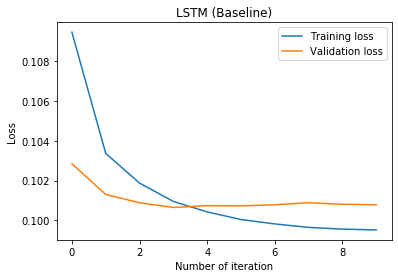

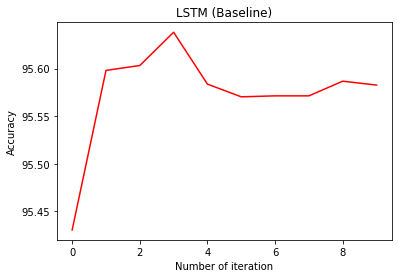

Mean time per epoch 1280.7581158638 seconds


In [24]:
# visualization loss 
iteration_list=range(len(loss_list))
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("LSTM (Baseline)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("LSTM (Baseline)")
plt.show()

print(f"Mean time per epoch {np.mean(epoch_times)} seconds") # returns time in sec 
#print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


## Baseline CNN

In [0]:
import torch.nn as nn
import torch.nn.functional as F

#hyper parameters
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 7
DROPOUT = 0.5

### model setup

In [0]:
#CNN class
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):    # N = batch size, T = sent len, K = emb dim
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

        
class CNN(nn.Module):
    def __init__(self, embedding_matrix, n_filters, filter_sizes, num_aux_targets, 
                 dropout, pad_idx=0,batch_normalizations=True):
        super().__init__()
        embedding_dim = embedding_matrix.shape[1]

        #pad index is at zero by default
        #self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_dim, padding_idx = pad_idx)
        self.embedding = nn.Embedding(embedding_matrix.shape[0], embedding_dim)
        # pretrained weights
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        #set to true to learn new word embeddings
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)

        #CNN
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim))
                                    for fs in filter_sizes
                                    ])
        
        # whether to use batch normalizations
        self.batch_n = batch_normalizations
        if self.batch_n is True:
            self.convs1_bn = nn.BatchNorm2d(num_features=n_filters)
            #self.fc1_bn = nn.BatchNorm1d(num_features=in_dim//2)
            #self.fc2_bn = nn.BatchNorm1d(num_features=output_dim)

        in_dim=len(filter_sizes) * n_filters
        
        self.dropout = nn.Dropout(dropout)
        #linear outs
        self.linear1 = nn.Linear(in_dim, in_dim)
        self.linear2 = nn.Linear(in_dim, in_dim)
        self.linear_out = nn.Linear(in_dim, 1)
        self.linear_aux_out = nn.Linear(in_dim, num_aux_targets)

        
    def forward(self, text):
        #text = [batch size, sent len]
        embedded = self.embedding(text)
        embedded = self.embedding_dropout(embedded)
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        if self.batch_n is True:
            #conved = [F.relu(self.convs1_bn(conv(embedded))).squeeze(3) for conv in self.convs] #conv => batchnorm => relu
            conved = [self.convs1_bn(F.tanh(conv(embedded))).squeeze(3) for conv in self.convs] #conv => tanh => batchnorm
            #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1] 
            pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
            #pooled_n = [batch size, n_filters]
        else:
            conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1] 
            pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
            #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]

        # if self.batch_n is True:
        #     cat = self.fc1_bn(self.fc1(cat))
        #     logit = self.fc2_bn(self.fc2(F.tanh(cat)))
        # else:
        #     logit = self.fc(cat)
        
        cat_linear1  = F.relu(self.linear1(cat))
        cat_linear2  = F.relu(self.linear2(cat))
        
        hidden = cat + cat_linear1 + cat_linear2
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        return out

In [0]:
x_train_torch = torch.tensor(x_train, dtype=torch.long).cuda()
x_test_torch = torch.tensor(x_test, dtype=torch.long).cuda()
y_train_torch = torch.tensor(np.hstack([y_train[:, np.newaxis], y_aux_train]), dtype=torch.float32).cuda()
y_test_torch = torch.tensor(np.hstack([y_test[:, np.newaxis], y_aux_test]), dtype=torch.float32).cuda()

### CNN (normalized, Embeddings: word2vec,glove)

In [33]:
%%time
train_dataset = data.TensorDataset(x_train_torch, y_train_torch)
test_dataset = data.TensorDataset(x_test_torch, y_test_torch)
#x_test_torch
all_test_preds = []

#set the number of model seeds to train
NUM_MODELS = 1
for model_idx in range(NUM_MODELS):
    print('Model CNN ', model_idx)
    seed_everything(42 + model_idx)

    model2 = CNN(embedding_matrix, N_FILTERS, FILTER_SIZES, y_aux_train.shape[-1], DROPOUT)
    model2.cuda()
    
    test_preds,epoch_times,loss_list_test,loss_list,accuracy_list = train_model(model2, train_dataset, test_dataset, output_dim=y_train_torch.shape[-1], 
                             loss_fn=nn.BCEWithLogitsLoss(reduction='mean'),n_epochs=4,enable_checkpoint_ensemble=True)
    all_test_preds.append(test_preds)
    print()
    
#prediction column
MODEL_NAME2 = 'predictionCNN'
test_private_comments[MODEL_NAME2] = np.mean(all_test_preds, axis=0)[:, 0]
test_private_comments_bool[MODEL_NAME2] = np.mean(all_test_preds, axis=0)[:, 0]

Model CNN  0
epoch : 0



Epoch 1/4 	 training_loss=0.1634 	 test_loss=0.1259 	 time=47.79s 	 Accuracy: 90603/97320 (93%)
Better accuracy at Epoch 0: accuracy = 93.0980271270037%
Better loss at Epoch 0: loss = 0.12587707305908832%
epoch : 1



Epoch 2/4 	 training_loss=0.1277 	 test_loss=0.1244 	 time=47.88s 	 Accuracy: 91209/97320 (94%)
Better accuracy at Epoch 1: accuracy = 93.72071516646116%
Better loss at Epoch 1: loss = 0.12436832669447723%
epoch : 2



Epoch 3/4 	 training_loss=0.1235 	 test_loss=0.1213 	 time=47.82s 	 Accuracy: 91598/97320 (94%)
Better accuracy at Epoch 2: accuracy = 94.12042745581587%
Better loss at Epoch 2: loss = 0.12125519367810002%
epoch : 3



Epoch 4/4 	 training_loss=0.1207 	 test_loss=0.1202 	 time=47.87s 	 Accuracy: 91762/97320 (94%)
Better accuracy at Epoch 3: accuracy = 94.28894369091657%
Better loss at Epoch 3: loss = 0.12016214606330147%

CPU times: user 2min 1s, sys: 1min 12s, total: 3min 13s
Wall time: 3min 13s


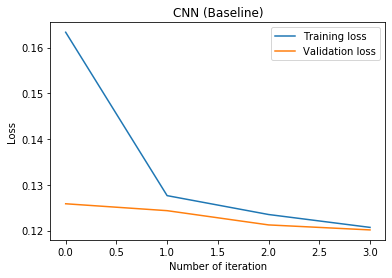

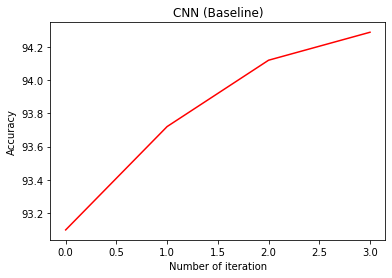

Mean time per epoch 47.84125369787216 seconds


In [34]:
# visualization loss 
iteration_list=range(len(loss_list))
plt.plot(iteration_list,loss_list, label='Training loss')
plt.plot(iteration_list,loss_list_test, label='Validation loss')
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN (Baseline)")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN (Baseline)")
plt.show()

print(f"Mean time per epoch {np.mean(epoch_times)} seconds") # returns time in sec 
#print(f"Best accuracy: {best_acc}  Best training loss: {min(loss_list)}  Best validation loss: {min(loss_list_test)}")


## save load predict helper functions

In [0]:
#save and load models
import pickle
with open("/content/model.pickle", "wb") as f:
     pickle.dump(model,f)


In [0]:
with open("/content/model.pickle", "rb") as f:
    model = pickle.load(f)

In [0]:
# submission = pd.DataFrame.from_dict({
#     'id': test['id'],
#     'prediction': np.mean(all_test_preds, axis=0)[:, 0]
# })

# submission.to_csv('submission.csv', index=False)

## Count model parameters

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The LSTM model has {count_parameters(model):,} trainable parameters')
print(f'The CNN model has {count_parameters(model2):,} trainable parameters')

The LSTM model has 1,671,687 trainable parameters
The CNN model has 903,207 trainable parameters


# Evaluations

## helper functions

Evaluate biases

In [0]:
#imports
from sklearn import metrics
import numpy as np 
import pandas as pd 

#only accepts true and false bools
#Define bias metrics, then evaluate our new model for bias using the validation set predictions

SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

#uncomment to show only bias metric
#bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
#bias_metrics_df

#NOTE use bettermetric.py for below method
#calculate final score
TOXICITY_COLUMN = 'target'
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
#uncomment to show overall metric    
#get_final_metric(bias_metrics_df, calculate_overall_auc(validate_df, MODEL_NAME))



Evaluate overall

In [0]:
import numpy as np
from sklearn.metrics import roc_auc_score


class JigsawEvaluator:
    def __init__(self, y_true, y_identity, power=-5, overall_model_weight=0.25):
        self.y = (y_true >= 0.5).astype(int)
        self.y_i = (y_identity >= 0.5).astype(int)
        self.n_subgroups = self.y_i.shape[1]
        self.power = power
        self.overall_model_weight = overall_model_weight

    @staticmethod
    def _compute_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except ValueError:
            return np.nan

    def _compute_subgroup_auc(self, i, y_pred):
        mask = self.y_i[:, i] == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bpsn_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y == 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def _compute_bnsp_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y != 1
        return self._compute_auc(self.y[mask], y_pred[mask])

    def compute_bias_metrics_for_model(self, y_pred):
        records = np.zeros((3, self.n_subgroups))
        for i in range(self.n_subgroups):
            records[0, i] = self._compute_subgroup_auc(i, y_pred)
            records[1, i] = self._compute_bpsn_auc(i, y_pred)
            records[2, i] = self._compute_bnsp_auc(i, y_pred)
        return records

    def _calculate_overall_auc(self, y_pred):
        return roc_auc_score(self.y, y_pred)

    def _power_mean(self, array):
        total = sum(np.power(array, self.power))
        return np.power(total / len(array), 1 / self.power)

    def get_final_metric(self, y_pred):
        bias_metrics = self.compute_bias_metrics_for_model(y_pred)
        bias_score = np.average(
            [
                self._power_mean(bias_metrics[0]),
                self._power_mean(bias_metrics[1]),
                self._power_mean(bias_metrics[2]),
            ]
        )
        overall_score = self.overall_model_weight * self._calculate_overall_auc(y_pred)
        bias_score = (1 - self.overall_model_weight) * bias_score
        return overall_score + bias_score


## evaluate (LSTM)

In [0]:
y_true = test_private_comments['toxicity'].values
y_identity = test_private_comments[identity_columns].values
y_pred = test_private_comments[MODEL_NAME].values

# evaluate overall
evaluator = JigsawEvaluator(y_true, y_identity)
auc_score = evaluator.get_final_metric(y_pred)
print(auc_score)

0.9220008824172555


In [0]:
#only bias metric
TOXICITY_COLUMN = 'toxicity'
bias_metrics_df = compute_bias_metrics_for_model(test_private_comments_bool, identity_columns, MODEL_NAME,'toxicity')
bias_metrics_df

#another overall auc
#get_final_metric(bias_metrics_df, calculate_overall_auc(test_private_comments_bool, MODEL_NAME))

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,538,0.815797,0.829668,0.965649
5,muslim,1054,0.831021,0.879873,0.953835
6,black,761,0.845252,0.854125,0.966948
7,white,1178,0.846389,0.845575,0.970711
4,jewish,411,0.898002,0.898252,0.964871
8,psychiatric_or_mental_illness,238,0.918579,0.928154,0.959443
0,male,2112,0.919556,0.921988,0.964829
1,female,2602,0.927033,0.934105,0.961628
3,christian,2109,0.928707,0.950542,0.950100


## evaluate (CNN)

In [40]:
y_true = test_private_comments['toxicity'].values
y_identity = test_private_comments[identity_columns].values
y_pred = test_private_comments_bool[MODEL_NAME].values

# evaluate overall
evaluator = JigsawEvaluator(y_true, y_identity)
auc_score = evaluator.get_final_metric(y_pred)
print(auc_score)

0.9076102781014211


In [42]:
#only bias metric
TOXICITY_COLUMN = 'toxicity'
bias_metrics_df = compute_bias_metrics_for_model(test_private_comments_bool, identity_columns, MODEL_NAME,'toxicity')
bias_metrics_df

#another overall auc
#get_final_metric(bias_metrics_df, calculate_overall_auc(test_private_comments_bool, MODEL_NAME))

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,538,0.808391,0.800457,0.962532
6,black,761,0.817128,0.809888,0.963577
5,muslim,1054,0.827205,0.849722,0.952649
7,white,1178,0.833330,0.788365,0.971980
4,jewish,411,0.888312,0.870983,0.963874
8,psychiatric_or_mental_illness,238,0.888688,0.921920,0.936671
0,male,2112,0.915667,0.901056,0.962512
1,female,2602,0.922339,0.914896,0.959904
3,christian,2109,0.924574,0.930022,0.951921
